In [1]:
from imblearn.metrics import geometric_mean_score
import numpy as np
import keras
import gc
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from keras import optimizers,regularizers
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn import metrics
import time
from datetime import datetime, timedelta
np.random.seed(13)
from sklearn import svm
import pandas as pd
import matplotlib.pyplot as plt
import math
from __future__ import division
from sklearn.model_selection import KFold
from sklearn.preprocessing import normalize


files=['AAPL','AMZN','PEP','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','BKNG','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
#files=['AAPL','AMZN','GOOGL','MSFT','FB','INTC','CSCO','CMCSA','NVDA','NFLX','ADBE','AMGN','TXN','AVGO','PYPL','GILD','COST','QCOM']       
  
prices=list()
sentiment=list()
for file in files:
    param = {
        'q': file, # Stock symbol (ex: "AAPL")
        'i': "900", # Interval size in seconds ("86400" = 1 day intervals)
        'x': "NASD", # INDEXNASDAQStock exchange symbol on which stock is traded (ex: "NASD")
        'p': "2Y" # Period (Ex: "1Y" = 1 year)
        }
    sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/intrinioDatasetUpdated/Sentiment/'+file+'.csv')
    price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDatasetUpdated/'+file+'.csv')
    #sentimentVector =  pd.read_csv('/home/andrea/Desktop/NLFF/intrinioDataset/SentimentFul/'+file+'.csv')
    #price= pd.read_csv('/home/andrea/Desktop/NLFF/TechnicalDataset/indexes'+file+'.csv')
    #alignment of data
    maxdata=max(sentimentVector['initTime'])
    mindata=min(sentimentVector['initTime'])
    price['Unnamed: 0'] = [datetime.strptime(row, '%Y-%m-%d %H:%M:%S') for row in price['Unnamed: 0']]
    price['Unnamed: 0'] = [row-timedelta(hours=8) for row in price['Unnamed: 0']]
    price=price[price['Unnamed: 0']>=mindata]
    price=price[price['Unnamed: 0']<=maxdata]
    print(file)
   
    sentimentVector=sentimentVector.drop(['Unnamed: 0', 'initTime' ], axis=1)
    meanvector=np.concatenate((sentimentVector,sentimentVector.rolling(5).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(10).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(15).mean()),axis=1)
    meanvector=np.concatenate((meanvector,sentimentVector.rolling(20).mean()),axis=1)
    price=price.drop(['Unnamed: 0'],axis=1)
    #['macd','macds', 'boll_ub', 'boll_lb','rsi_6','rsi_12','vr_6_sma','wr_10','wr_6''close_10_sma''tr''middle_{}_sma'
    #df['dma'] = df['close_10_sma'] - df['close_50_sma'] pdi'] = cls._get_pdi(df, 14)df['mdi'] = cls._get_mdi(df, 14)
    #df['dx'] = cls._get_dx(df, 14) df['adx'] = df['dx_6_ema'] df['adxr'] = df['adx_6_ema']]
    #
    sentiment.append(meanvector)
    prices.append(price)

/home/andrea/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


AAPL
AMZN
PEP
GOOGL
MSFT
FB
INTC
CSCO
CMCSA
NVDA
NFLX
BKNG
ADBE
AMGN
TXN
AVGO
PYPL
GILD
COST
QCOM


In [2]:
def smote(x,y):
    X_resampled, y_resampled = SMOTE().fit_sample(x, y)
    #print('check',sum(y_resampled)/len(y_resampled))
    return X_resampled,y_resampled
def balance(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    nindex=min(len(posindex[0]),len(negindex[0]))

    #for i in range(1,nindex):
    yt=np.concatenate((y[posindex[0][0:nindex]],y[negindex[0][0:nindex]]))
    xt=np.concatenate((x[posindex[0][0:nindex]],x[negindex[0][0:nindex]]))
    
    return xt,yt

def balanceup(x,y):
    posindex=np.where( y == 1 )
    negindex=np.where( y == 0 )
    xt=[]
    yt=[]
    yindex=[]
    
    if(len(posindex[0])!=0 and len(negindex[0])!=0):
       
        nindex=max(len(posindex[0]),len(negindex[0]))
        mini=min(len(posindex[0]),len(negindex[0]))
        diff=nindex-mini
        u=0
        for i in range(0,mini):
            yt.append(y[posindex[0][i]])
            yt.append(y[negindex[0][i]])
            xt.append(x[posindex[0][i]])
            xt.append(x[negindex[0][i]])
        #print('first',sum(yt)/len(yt)) 
        if(len(posindex[0])>len(negindex[0])):
            toextract=negindex
            enter=posindex
        else:
            toextract=posindex
            enter=negindex
        if(diff!=0 and len(toextract[0])!=0):
            for i in range(0,diff):
                r=np.random.randint(0,len(toextract))
                yt.append(y[toextract[0][r]])
                xt.append(x[toextract[0][r]])
                yt.append(y[enter[0][mini+i]])
                xt.append(x[enter[0][mini+i]])
    else:
        #print('Unbalance')
        u=1
        xt=x
        yt=y
    #print(sum(yt)/len(yt))              
    return xt,yt,u
                    

In [3]:
def buildModel(l,n,d,le):
    model = Sequential()  
    model.add(Dense(n, input_dim=40,kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/2), kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU())
    model.add(Dropout(d))
    model.add(Dense(math.floor(n/4), kernel_regularizer=regularizers.l2(0.01),activity_regularizer=regularizers.l2(l))) 
    model.add(BatchNormalization()) 
    model.add(LeakyReLU()) 
    model.add(Dense(1, activation='sigmoid')) 
    opt=optimizers.Adam(lr=le)
    model.compile(optimizer=opt,loss='binary_crossentropy', metrics=['accuracy'])

    return model
def reset_weights(model):
    session=K.get_session()
    for layer in model.layers:
        if(hasattr(layer,'kernel_initializer')):
            layer.kernel.initializer.run(session=session)
            
           


Working on... AAPL
15.571701720841297
0.005338458253266777
working on d,u and l,le 0.5 64 0.01 0.001


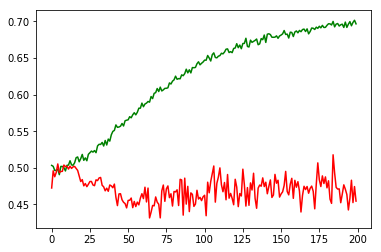

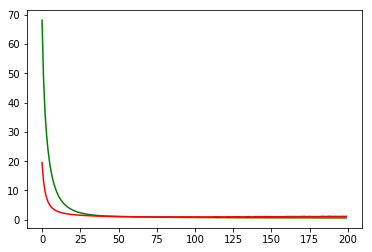

working on d,u and l,le 0.5 64 0.01 0.0001


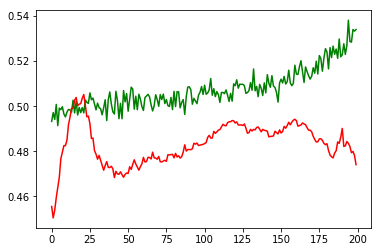

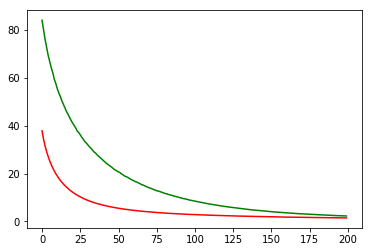

working on d,u and l,le 0.5 128 0.01 0.001


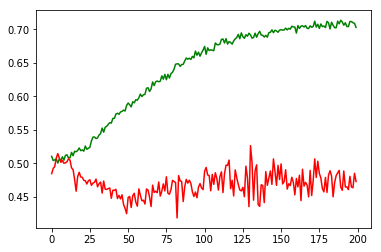

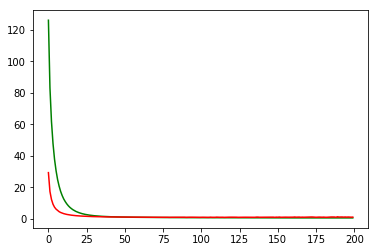

working on d,u and l,le 0.5 128 0.01 0.0001


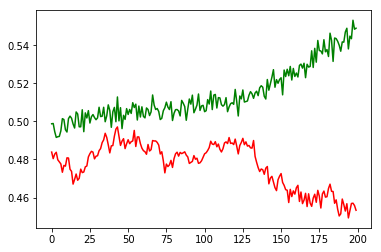

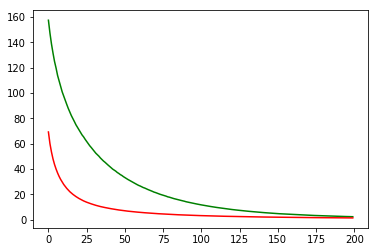

working on d,u and l,le 0.5 256 0.01 0.001


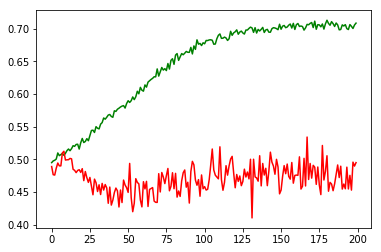

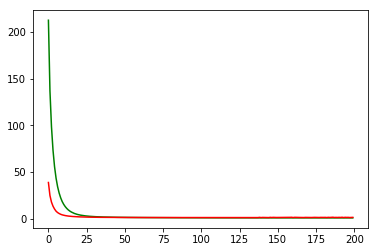

working on d,u and l,le 0.5 256 0.01 0.0001


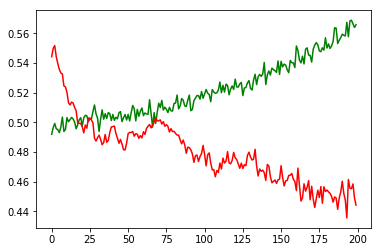

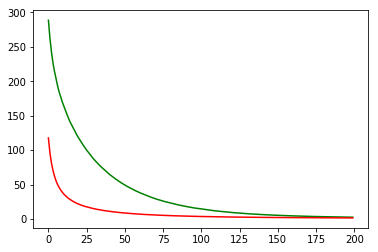

maxd,maxu,maxl,maxle: 0.5 256 0.01 0.001
Chart for BEST MODEL FOR: AAPL


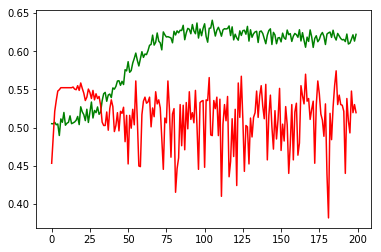

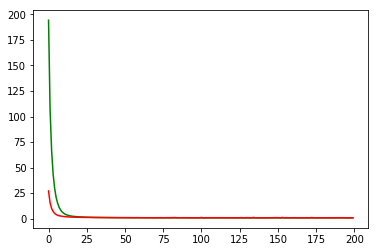

F1,score 0.65698041692988
G-score: 0.33217850019941075
Accuracy 0.5194690261266928
Window: 140
[[ 67 439]
 [104 520]]
Vol pos 3.5631355989417206
Vol neg 2.75355032324729
Real Percentage of gain: 16.203892776105867
Percentage of gain: 0.5277723637659394
Total gain: 596.3827710555115
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 59 319]
 [ 60 315]]
753/753 [==============================] - 0s 28us/step
[0.8202134790331878, 0.49667994689893913]
Percentile:  1
[[ 4 64]
 [16 68]]
152/152 [==============================] - 0s 35us/step
[1.1241303745069002, 0.4736842113105874]
Percentile:  2
[[ 4 56]
 [ 9 70]]
139/139 [==============================] - 0s 38us/step
[0.8961622584209168, 0.5323741007194245]
Percentile:  3
[[ 0  0]
 [10 39]]
49/49 [==============================] - 0s 50us/step
[0.5419611091516456, 0.7959183673469388]
Percentile:  4
[[ 0  0]
 [ 9 26]]
35/35 [==============================] - 0s 66us/step
[0.6002408793994358, 0.7428571428571429]
000000000000

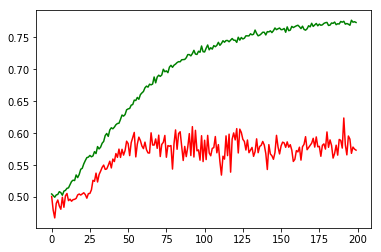

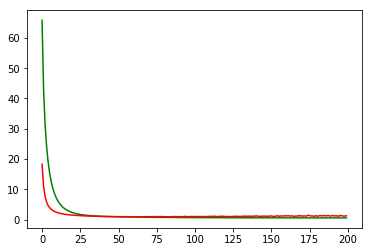

working on d,u and l,le 0.5 64 0.01 0.0001


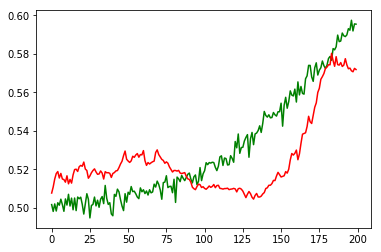

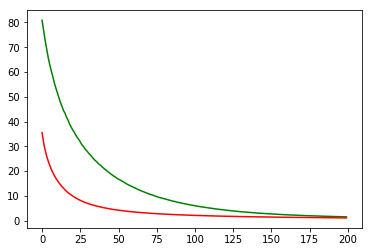

working on d,u and l,le 0.5 128 0.01 0.001


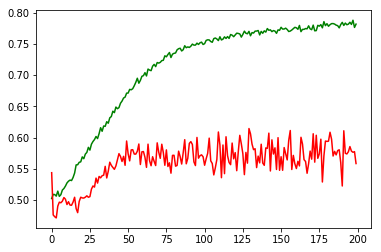

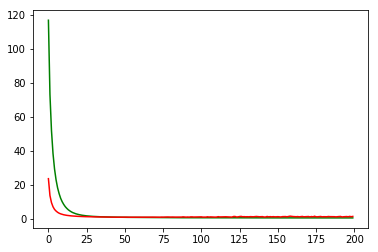

working on d,u and l,le 0.5 128 0.01 0.0001


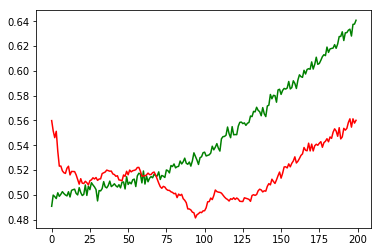

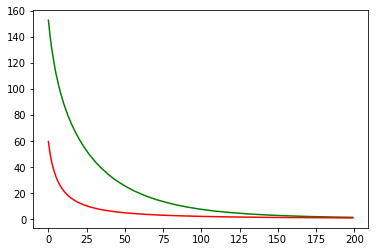

working on d,u and l,le 0.5 256 0.01 0.001


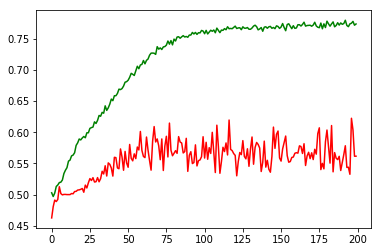

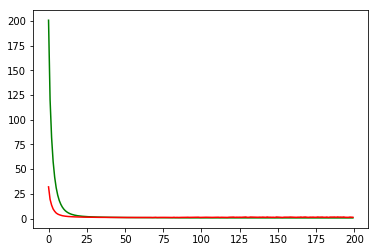

working on d,u and l,le 0.5 256 0.01 0.0001


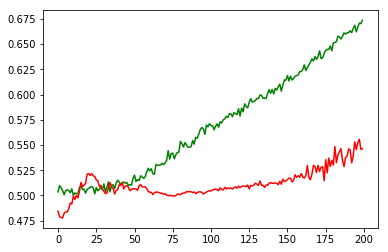

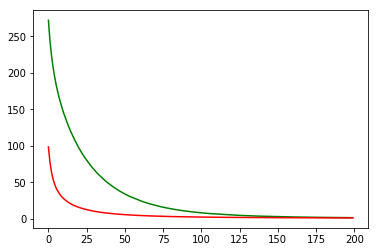

maxd,maxu,maxl,maxle: 0.5 64 0.01 0.001
Chart for BEST MODEL FOR: AMZN


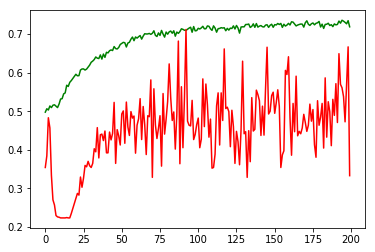

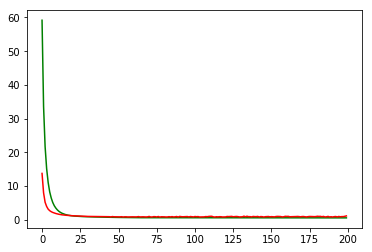

F1,score 0.3105022831050228
G-score: 0.3989190888966038
Accuracy 0.33303886931060483
Window: 140
[[207  44]
 [711 170]]
Vol pos 2.0649554457784562
Vol neg 2.511738418465442
Real Percentage of gain: -139.28829883830727
Percentage of gain: -0.9875214689778541
Total gain: -1117.8743028829308
000000000000000000000000000000000000000000000000
Percentile:  0
[[171  28]
 [356  75]]
630/630 [==============================] - 0s 27us/step
[1.0973425138564337, 0.3904761907600221]
Percentile:  1
[[ 23  13]
 [277  72]]
385/385 [==============================] - 0s 33us/step
[1.2117945873892153, 0.24675324675324675]
Percentile:  2
[[13  3]
 [43 17]]
76/76 [==============================] - 0s 48us/step
[0.926335849260029, 0.39473684210526316]
Percentile:  3
[[ 0  0]
 [28  5]]
33/33 [==============================] - 0s 63us/step
[1.4422501867467707, 0.15151515151515152]
Percentile:  4
[[0 0]
 [6 0]]
6/6 [==============================] - 0s 127us/step
[1.5724632740020752, 0.0]
0000000000000000000000

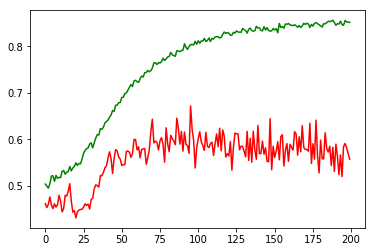

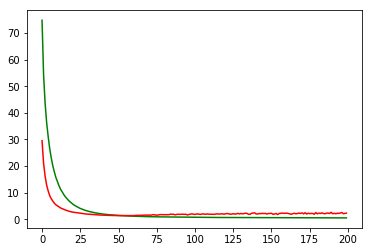

working on d,u and l,le 0.5 64 0.01 0.0001


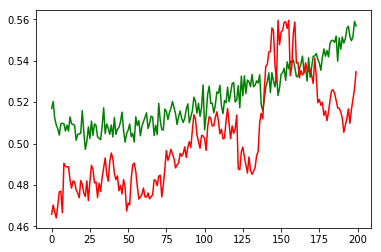

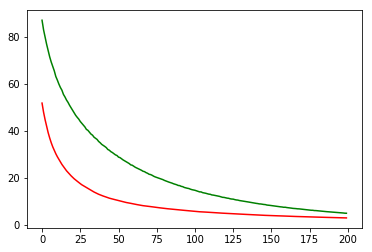

working on d,u and l,le 0.5 128 0.01 0.001


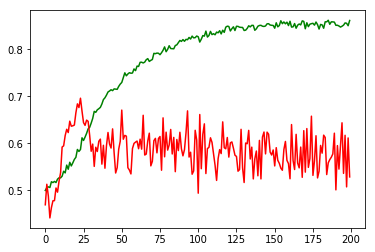

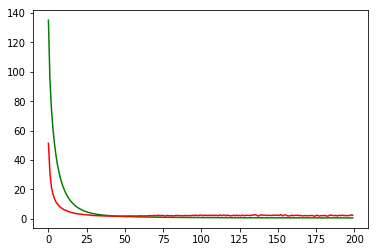

working on d,u and l,le 0.5 128 0.01 0.0001


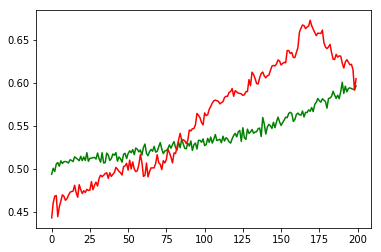

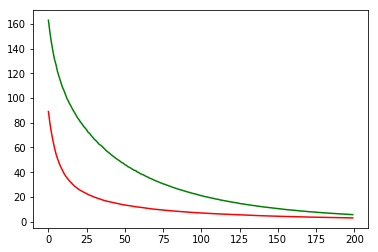

working on d,u and l,le 0.5 256 0.01 0.001


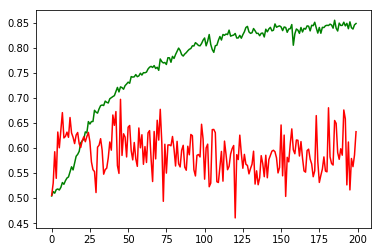

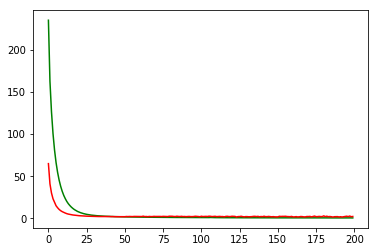

working on d,u and l,le 0.5 256 0.01 0.0001


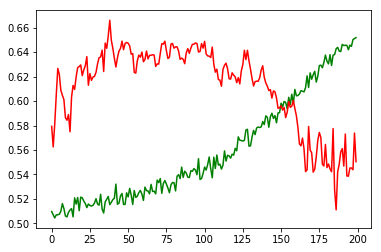

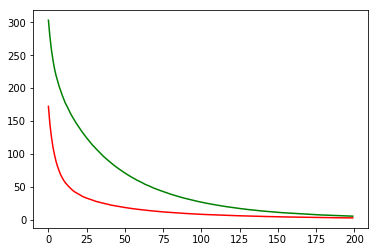

maxd,maxu,maxl,maxle: 0.5 256 0.01 0.001
Chart for BEST MODEL FOR: PEP


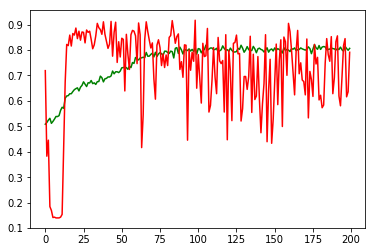

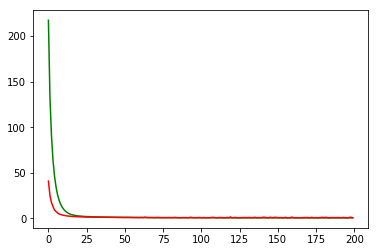

F1,score 0.8714555765595462
G-score: 0.6989283117239967
Accuracy 0.7910906298003072
Window: 140
[[ 54  37]
 [ 99 461]]
Vol pos 2.2621973210530046
Vol neg 1.4014725156507115
Real Percentage of gain: 100.52104293129986
Percentage of gain: 1.49682236284762
Total gain: 974.4313582138005
000000000000000000000000000000000000000000000000
Percentile:  0
[[35 37]
 [20 90]]
182/182 [==============================] - 0s 37us/step
[0.7144443582702469, 0.686813187795681]
Percentile:  1
[[ 19   0]
 [ 39 103]]
161/161 [==============================] - 0s 38us/step
[0.5242082204507745, 0.7577639751552795]
Percentile:  2
[[  0   0]
 [ 38 148]]
186/186 [==============================] - 0s 40us/step
[0.4952120476512499, 0.7956989208857218]
Percentile:  3
[[ 0  0]
 [ 2 74]]
76/76 [==============================] - 0s 47us/step
[0.27626810732640716, 0.9736842105263158]
Percentile:  4
[[45]]
45/45 [==============================] - 0s 49us/step
[0.21430518362257217, 1.0]
0000000000000000000000000000000000

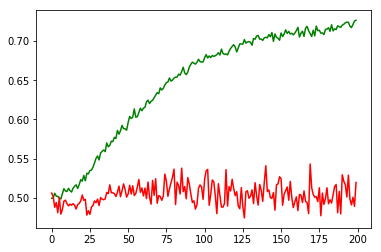

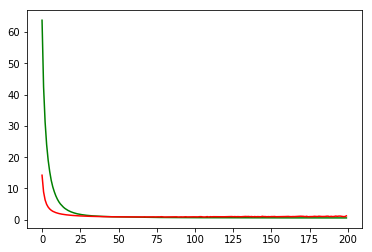

working on d,u and l,le 0.5 64 0.01 0.0001


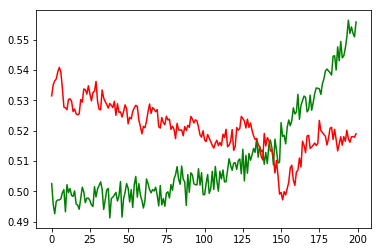

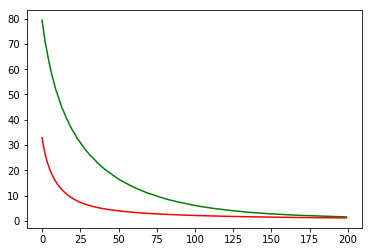

working on d,u and l,le 0.5 128 0.01 0.001


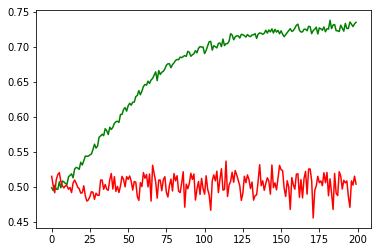

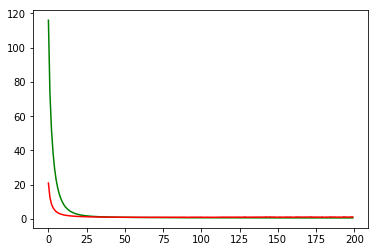

working on d,u and l,le 0.5 128 0.01 0.0001


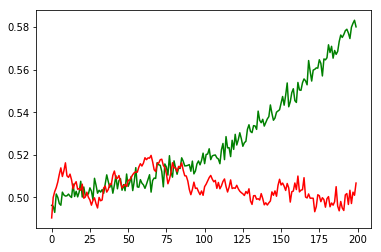

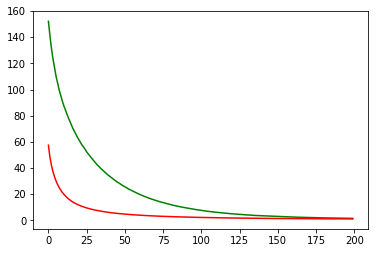

working on d,u and l,le 0.5 256 0.01 0.001


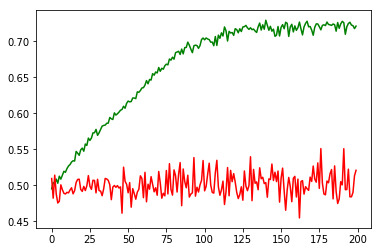

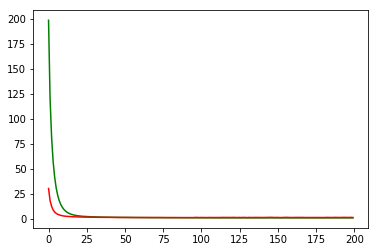

working on d,u and l,le 0.5 256 0.01 0.0001


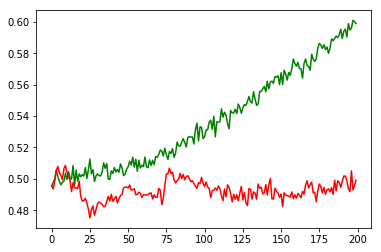

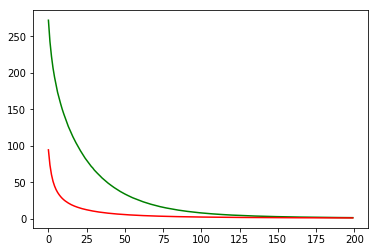

maxd,maxu,maxl,maxle: 0.5 256 0.01 0.001
Chart for BEST MODEL FOR: GOOGL


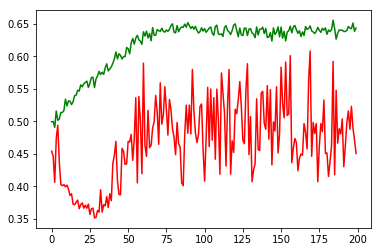

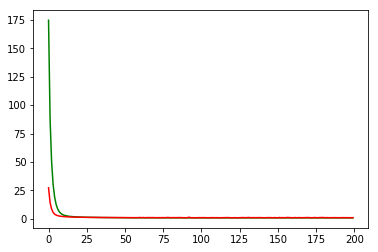

F1,score 0.5028022417934348
G-score: 0.44650316837070636
Accuracy 0.450442479194793
Window: 140
[[195 260]
 [361 314]]
Vol pos 2.925377417217772
Vol neg 2.9798118874631117
Real Percentage of gain: -31.60396953710237
Percentage of gain: -0.31986378473517363
Total gain: -361.4460767507462
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 99 133]
 [ 81  98]]
411/411 [==============================] - 0s 41us/step
[0.85896247668858, 0.47931873653346896]
Percentile:  1
[[ 41  70]
 [133 119]]
363/363 [==============================] - 0s 33us/step
[0.8826013491501822, 0.440771349944359]
Percentile:  2
[[51 46]
 [79 30]]
206/206 [==============================] - 0s 32us/step
[0.9429930957775672, 0.3932038840738315]
Percentile:  3
[[ 3 11]
 [47 40]]
101/101 [==============================] - 0s 39us/step
[0.9387027101941628, 0.42574257543771576]
Percentile:  4
[[ 0  0]
 [21 26]]
47/47 [==============================] - 0s 49us/step
[0.6303517349222874, 0.5531914982389896]
000

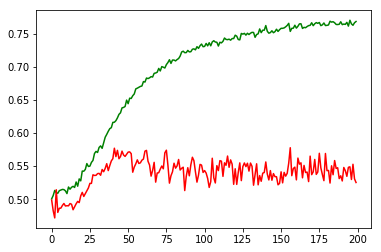

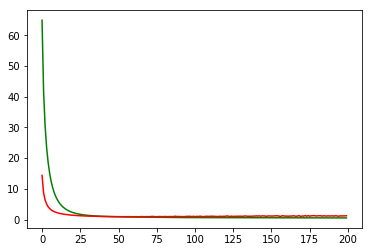

working on d,u and l,le 0.5 64 0.01 0.0001


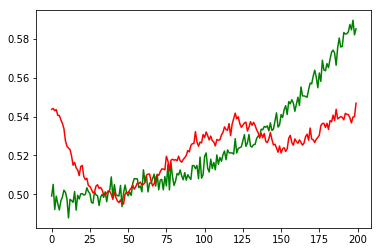

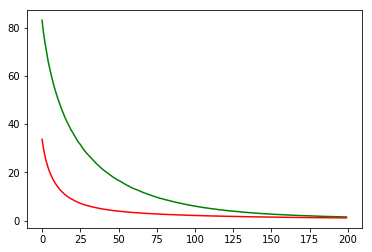

working on d,u and l,le 0.5 128 0.01 0.001


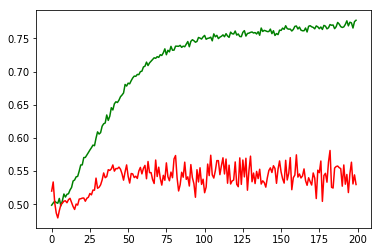

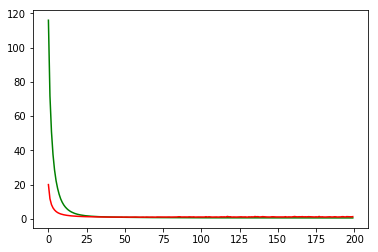

working on d,u and l,le 0.5 128 0.01 0.0001


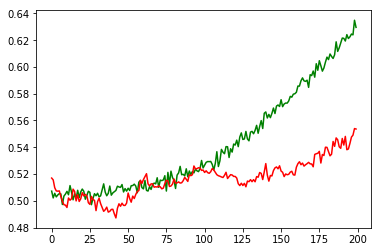

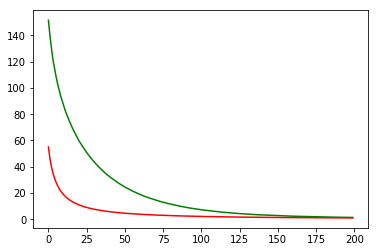

working on d,u and l,le 0.5 256 0.01 0.001


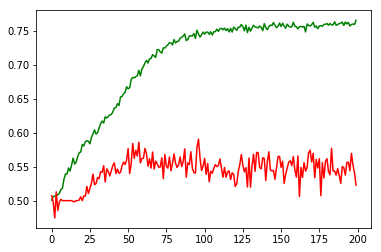

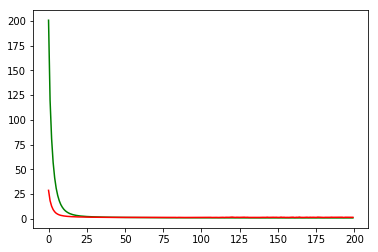

working on d,u and l,le 0.5 256 0.01 0.0001


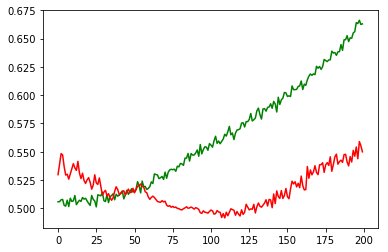

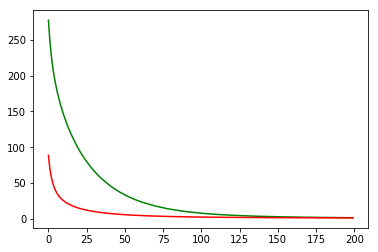

maxd,maxu,maxl,maxle: 0.5 128 0.01 0.0001
Chart for BEST MODEL FOR: MSFT


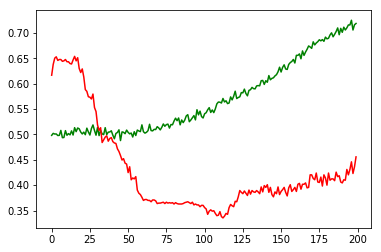

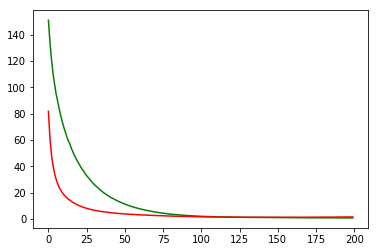

F1,score 0.513064133016627
G-score: 0.45577172269300525
Accuracy 0.4557522112289361
Window: 140
[[191 228]
 [387 324]]
Vol pos 1.3476465158343394
Vol neg 1.7655878013778397
Real Percentage of gain: 13.287089614227089
Percentage of gain: -0.3467243736218466
Total gain: -391.7985421926867
000000000000000000000000000000000000000000000000
Percentile:  0
[[142 150]
 [101 151]]
544/544 [==============================] - 0s 30us/step
[1.186418585917529, 0.5386029411764706]
Percentile:  1
[[ 37  37]
 [139 100]]
313/313 [==============================] - 0s 32us/step
[1.1008100444897295, 0.4376996807016123]
Percentile:  2
[[  8  15]
 [101  39]]
163/163 [==============================] - 0s 37us/step
[1.5149624106342807, 0.2883435582822086]
Percentile:  3
[[ 3 17]
 [39 22]]
81/81 [==============================] - 0s 43us/step
[2.836598536114634, 0.30864197530864196]
Percentile:  4
[[ 1  9]
 [ 7 11]]
28/28 [==============================] - 0s 53us/step
[3.977749824523926, 0.4285714328289032]
00

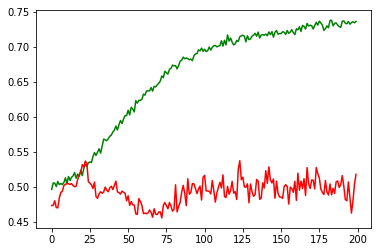

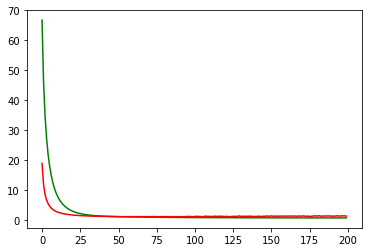

working on d,u and l,le 0.5 64 0.01 0.0001


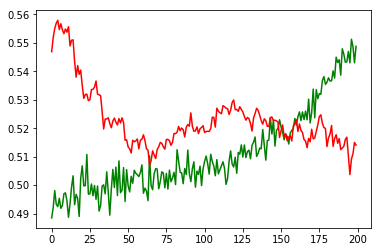

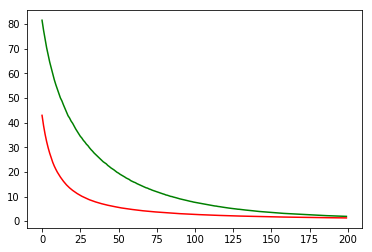

working on d,u and l,le 0.5 128 0.01 0.001


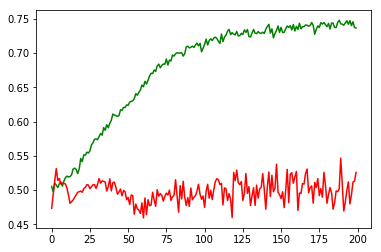

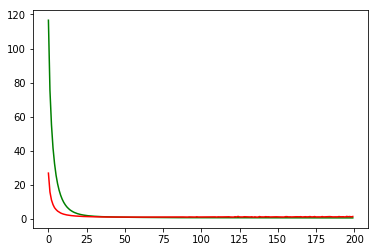

working on d,u and l,le 0.5 128 0.01 0.0001


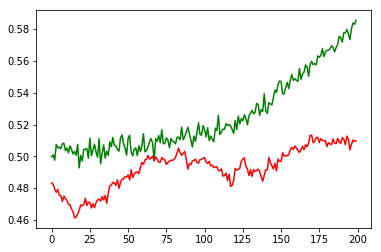

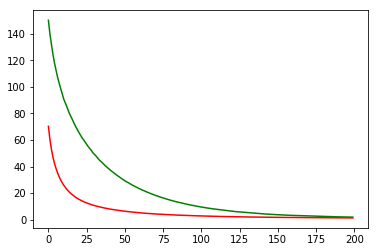

working on d,u and l,le 0.5 256 0.01 0.001


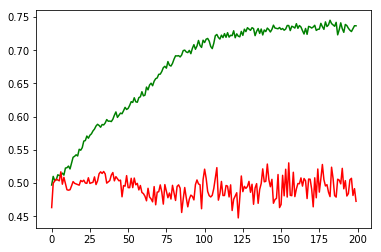

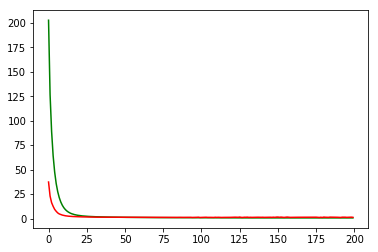

working on d,u and l,le 0.5 256 0.01 0.0001


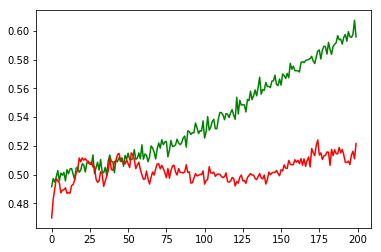

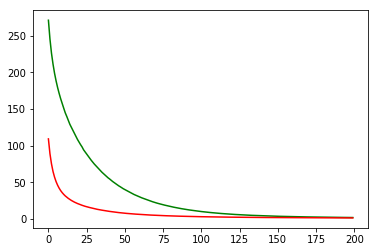

maxd,maxu,maxl,maxle: 0.5 128 0.01 0.001
Chart for BEST MODEL FOR: FB


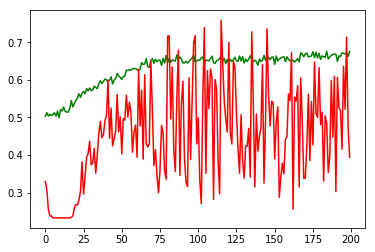

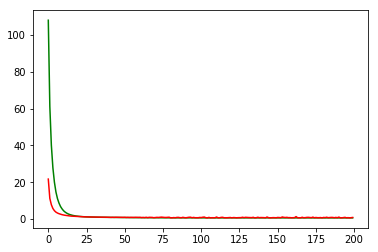

F1,score 0.39506172839506176
G-score: 0.4664582019970211
Accuracy 0.393992934020585
Window: 140
[[222  41]
 [645 224]]
Vol pos 2.578037917733467
Vol neg 3.4025033356702585
Real Percentage of gain: -104.8627381776765
Percentage of gain: -1.0462123471384022
Total gain: -1184.3123769606711
000000000000000000000000000000000000000000000000
Percentile:  0
[[173  39]
 [239  71]]
522/522 [==============================] - 0s 40us/step
[0.82447247989333, 0.46743295041994115]
Percentile:  1
[[ 35   2]
 [292 139]]
468/468 [==============================] - 0s 38us/step
[0.8065622102501045, 0.3717948720495925]
Percentile:  2
[[13  0]
 [78 14]]
105/105 [==============================] - 0s 52us/step
[1.1002536807741439, 0.2571428594135103]
Percentile:  3
[[ 0  0]
 [14  0]]
14/14 [==============================] - 0s 86us/step
[1.0143550634384155, 0.0]
Percentile:  4
[[ 0  0]
 [21  0]]
21/21 [==============================] - 0s 49us/step
[0.9621486067771912, 0.0]
00000000000000000000000000000000000

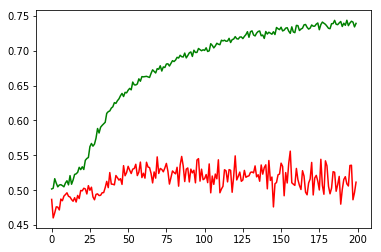

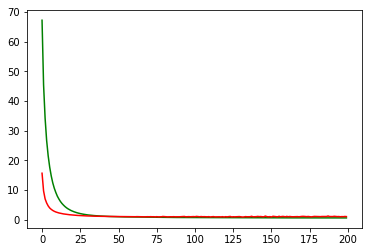

working on d,u and l,le 0.5 64 0.01 0.0001


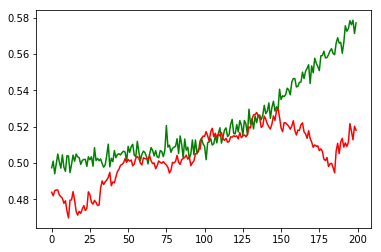

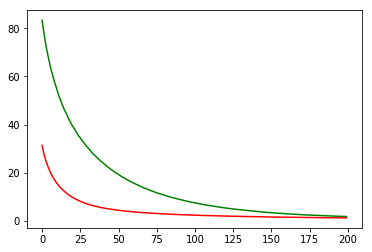

working on d,u and l,le 0.5 128 0.01 0.001


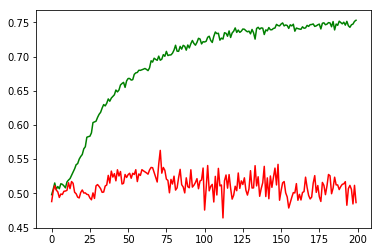

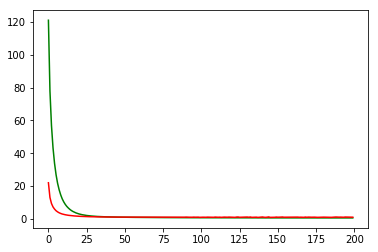

working on d,u and l,le 0.5 128 0.01 0.0001


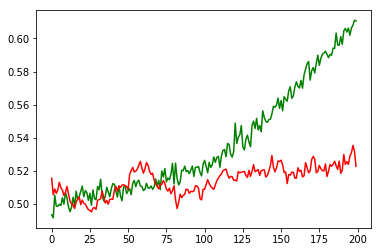

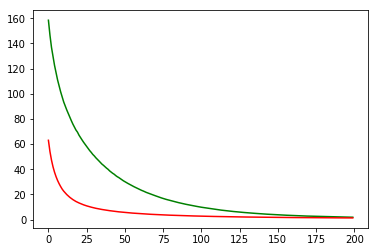

working on d,u and l,le 0.5 256 0.01 0.001


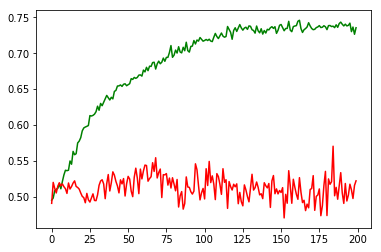

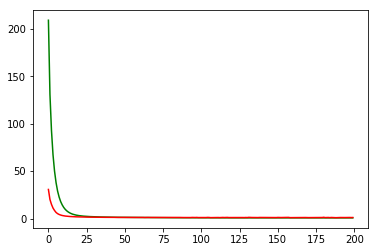

working on d,u and l,le 0.5 256 0.01 0.0001


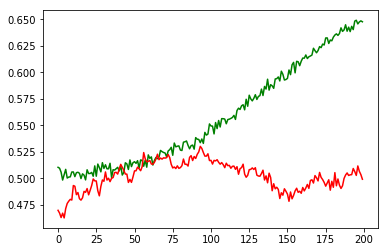

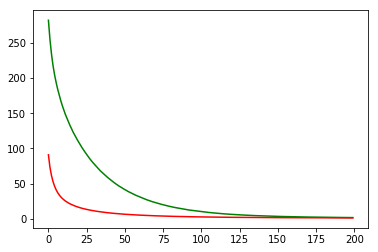

maxd,maxu,maxl,maxle: 0.5 128 0.01 0.0001
Chart for BEST MODEL FOR: INTC


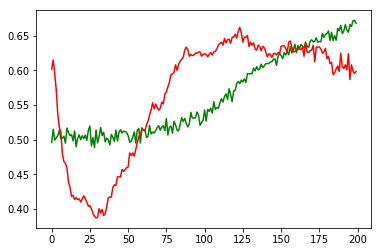

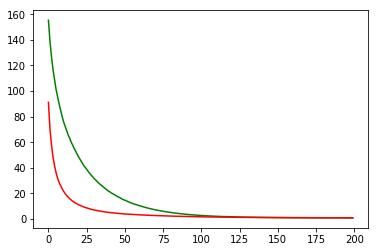

F1,score 0.6459143968871595
G-score: 0.5956726170894621
Accuracy 0.598056539840496
Window: 140
[[262 186]
 [269 415]]
Vol pos 2.3717923508616705
Vol neg 2.2687554501981007
Real Percentage of gain: 85.14965546882877
Percentage of gain: 0.5065544979622042
Total gain: 573.4196916932151
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 74  42]
 [103 135]]
354/354 [==============================] - 0s 50us/step
[0.9011932584525502, 0.5903954802259888]
Percentile:  1
[[ 64  50]
 [ 83 145]]
342/342 [==============================] - 0s 54us/step
[0.7757672761615954, 0.611111110762546]
Percentile:  2
[[66 61]
 [64 87]]
278/278 [==============================] - 0s 55us/step
[0.8957424078056281, 0.5503597127662289]
Percentile:  3
[[38 25]
 [11 40]]
114/114 [==============================] - 0s 59us/step
[0.8622526850616723, 0.6842105242243984]
Percentile:  4
[[20  8]
 [ 7  7]]
42/42 [==============================] - 0s 118us/step
[0.7730779307229179, 0.6428571428571429]
000000

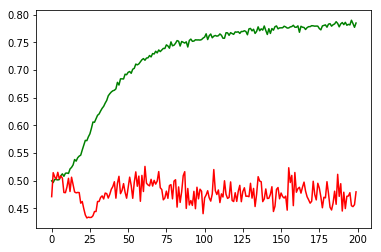

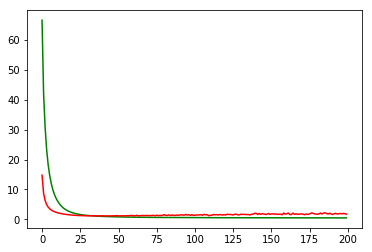

working on d,u and l,le 0.5 64 0.01 0.0001


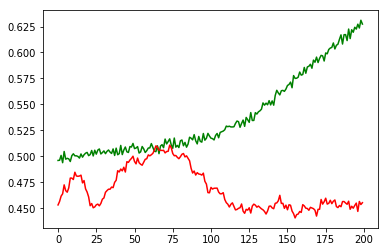

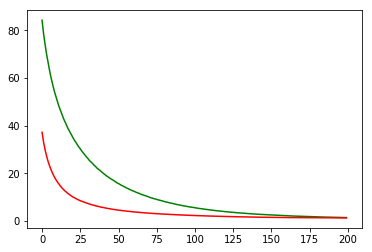

working on d,u and l,le 0.5 128 0.01 0.001


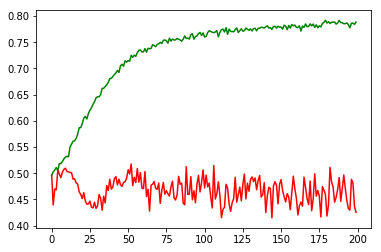

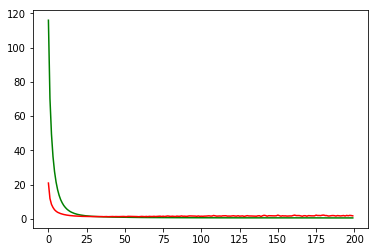

working on d,u and l,le 0.5 128 0.01 0.0001


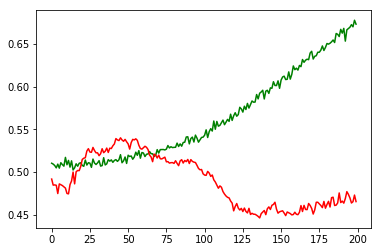

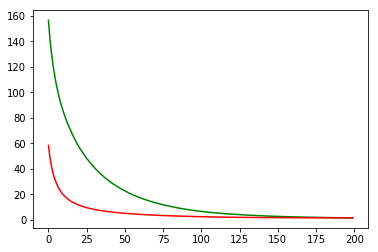

working on d,u and l,le 0.5 256 0.01 0.001


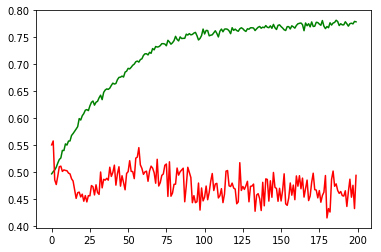

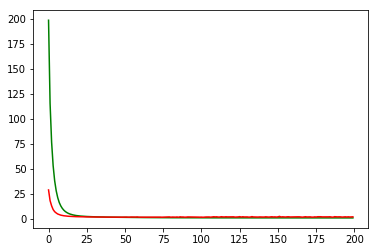

working on d,u and l,le 0.5 256 0.01 0.0001


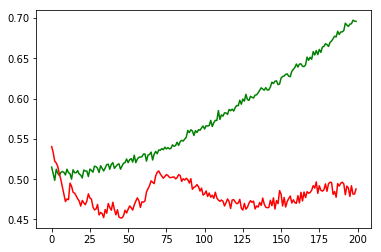

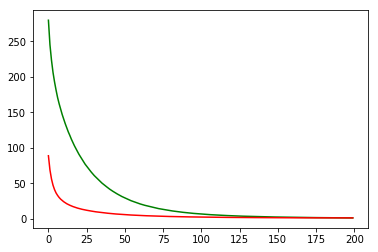

maxd,maxu,maxl,maxle: 0.5 256 0.01 0.001
Chart for BEST MODEL FOR: CSCO


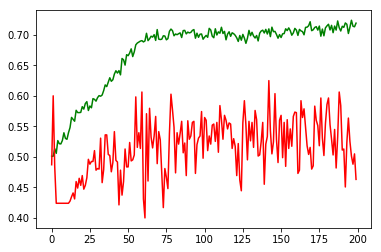

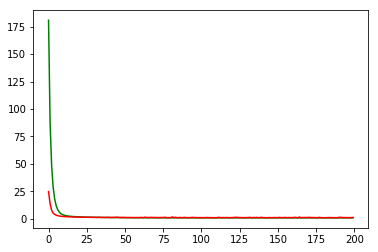

F1,score 0.379876796714579
G-score: 0.4484446120484852
Accuracy 0.4631111104223463
Window: 140
[[336 141]
 [463 185]]
Vol pos 2.183257001488047
Vol neg 1.5469190701913427
Real Percentage of gain: 18.00836162454414
Percentage of gain: 0.18056691500417907
Total gain: 203.13777937970144
000000000000000000000000000000000000000000000000
Percentile:  0
[[137  83]
 [250  46]]
516/516 [==============================] - 0s 47us/step
[1.1037569506916889, 0.3546511627906977]
Percentile:  1
[[ 82  14]
 [144  83]]
323/323 [==============================] - 0s 55us/step
[1.035003628431828, 0.5108359133126935]
Percentile:  2
[[33 17]
 [47 41]]
138/138 [==============================] - 0s 68us/step
[0.9649648597275001, 0.5362318840579711]
Percentile:  3
[[53  5]
 [14 14]]
86/86 [==============================] - 0s 57us/step
[0.6443238050438637, 0.7790697674418605]
Percentile:  4
[[30 22]
 [ 6  0]]
58/58 [==============================] - 0s 54us/step
[0.8144282082031513, 0.51724138342101]
0000000000

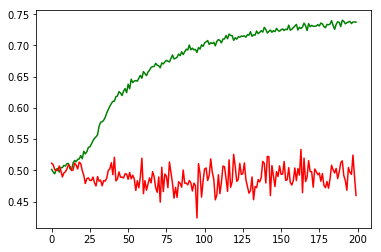

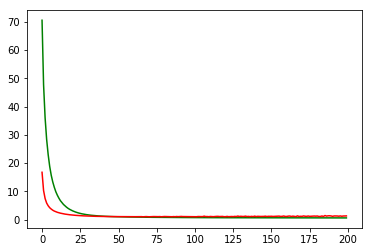

working on d,u and l,le 0.5 64 0.01 0.0001


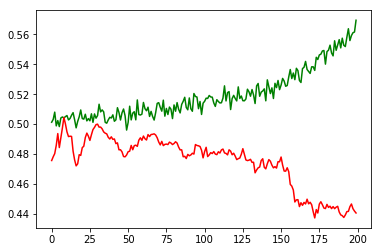

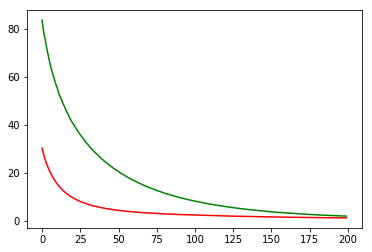

working on d,u and l,le 0.5 128 0.01 0.001


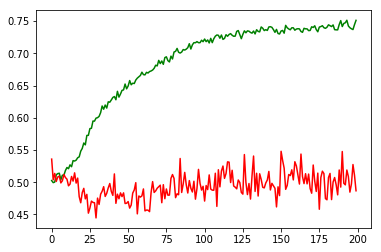

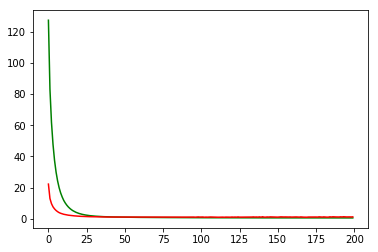

working on d,u and l,le 0.5 128 0.01 0.0001


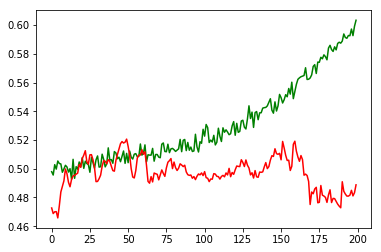

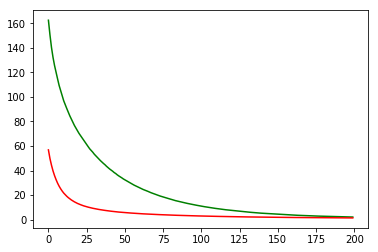

working on d,u and l,le 0.5 256 0.01 0.001


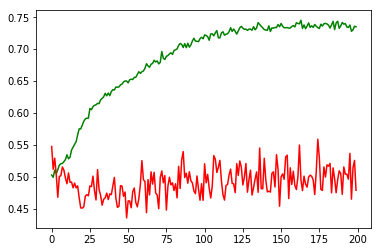

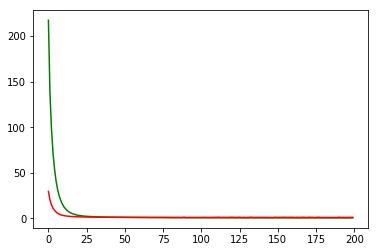

working on d,u and l,le 0.5 256 0.01 0.0001


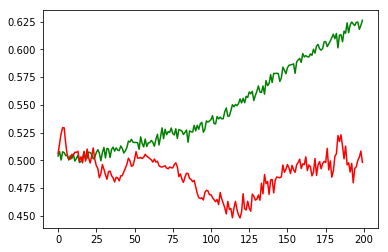

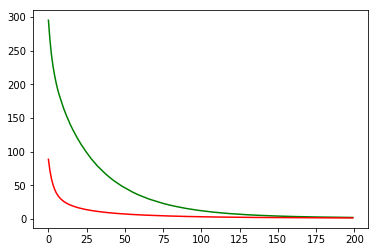

maxd,maxu,maxl,maxle: 0.5 256 0.01 0.0001
Chart for BEST MODEL FOR: CMCSA


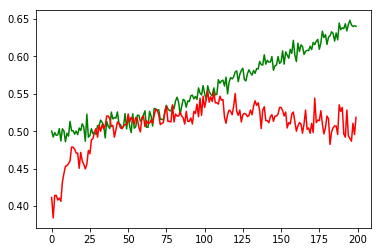

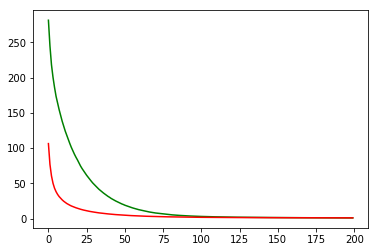

F1,score 0.5874337623012869
G-score: 0.4914560295988126
Accuracy 0.518551235696031
Window: 140
[[199 341]
 [204 388]]
Vol pos 2.6616954859750894
Vol neg 3.067241985228451
Real Percentage of gain: 76.13255669015778
Percentage of gain: -0.0964943742774984
Total gain: -109.23163168212818
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 86 141]
 [ 60 141]]
428/428 [==============================] - 0s 55us/step
[1.0435379431626508, 0.5303738314971745]
Percentile:  1
[[ 76 121]
 [ 92 212]]
501/501 [==============================] - 0s 73us/step
[1.0427587320228775, 0.5748502999960543]
Percentile:  2
[[10 32]
 [48 26]]
116/116 [==============================] - 0s 85us/step
[1.1519169643007476, 0.31034482784312345]
Percentile:  3
[[14 46]
 [ 4  8]]
72/72 [==============================] - 0s 130us/step
[1.1049885484907362, 0.3055555555555556]
Percentile:  4
[[12  1]
 [ 0  0]]
13/13 [==============================] - 0s 161us/step
[0.93304044008255, 0.9230769276618958]
00000

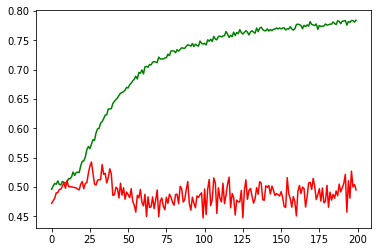

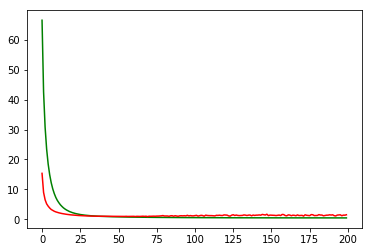

working on d,u and l,le 0.5 64 0.01 0.0001


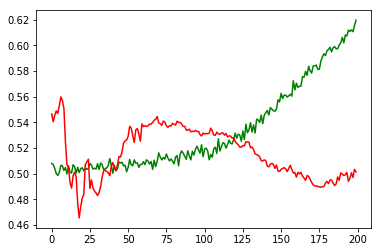

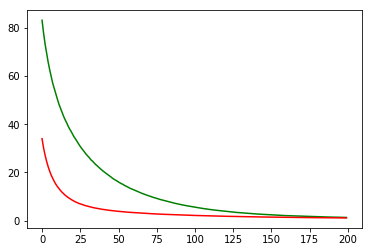

working on d,u and l,le 0.5 128 0.01 0.001


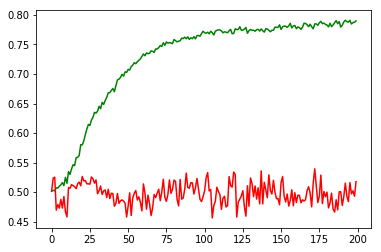

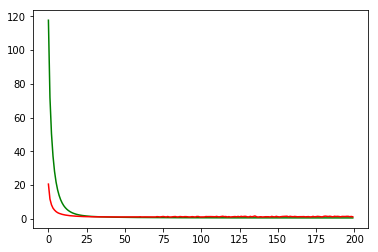

working on d,u and l,le 0.5 128 0.01 0.0001


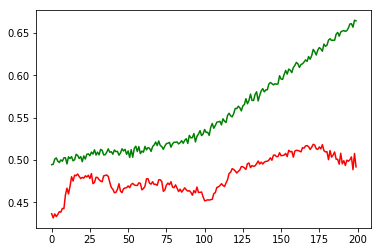

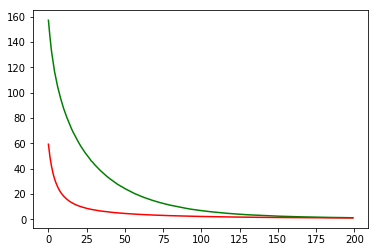

working on d,u and l,le 0.5 256 0.01 0.001


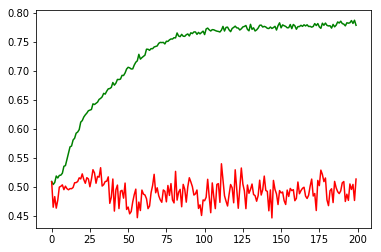

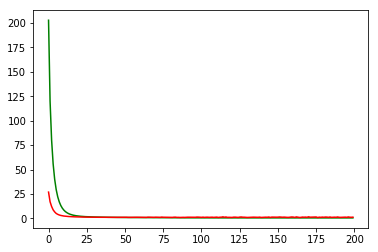

working on d,u and l,le 0.5 256 0.01 0.0001


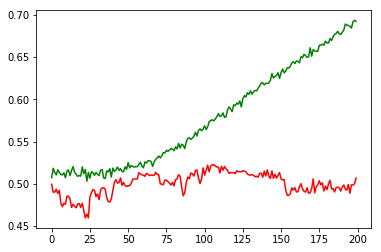

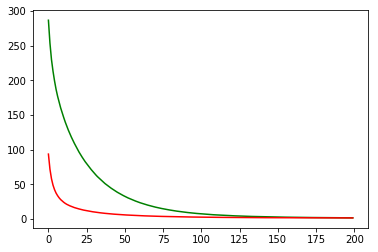

maxd,maxu,maxl,maxle: 0.5 128 0.01 0.001
Chart for BEST MODEL FOR: NVDA


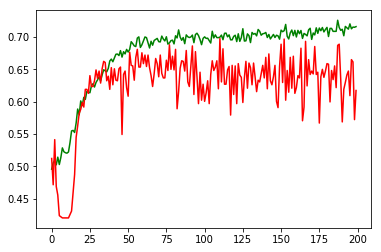

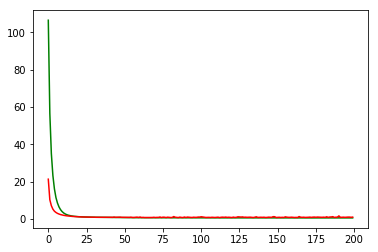

F1,score 0.6218340611353711
G-score: 0.6253406532188269
Accuracy 0.6174911662883557
Window: 140
[[343 133]
 [300 356]]
Vol pos 3.9677730599591494
Vol neg 3.4501084087657707
Real Percentage of gain: 328.0387428076476
Percentage of gain: 1.1303678691836279
Total gain: 1279.5764279158668
000000000000000000000000000000000000000000000000
Percentile:  0
[[226  87]
 [135 111]]
559/559 [==============================] - 0s 45us/step
[1.0483404643207201, 0.6028622541050151]
Percentile:  1
[[ 90  27]
 [114 106]]
337/337 [==============================] - 0s 54us/step
[0.9168641015400872, 0.5816023753021874]
Percentile:  2
[[22  9]
 [14 58]]
103/103 [==============================] - 0s 62us/step
[0.8417384372029489, 0.7766990291262136]
Percentile:  3
[[ 5 10]
 [22 43]]
80/80 [==============================] - 0s 99us/step
[1.0506999373435975, 0.6]
Percentile:  4
[[ 0  0]
 [15 36]]
51/51 [==============================] - 0s 75us/step
[0.5699513627617967, 0.7058823529411765]
000000000000000000000

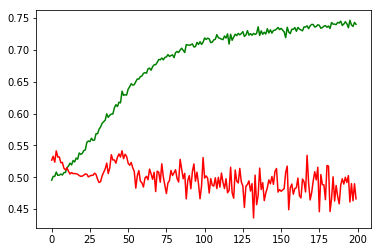

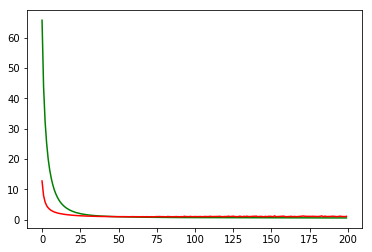

working on d,u and l,le 0.5 64 0.01 0.0001


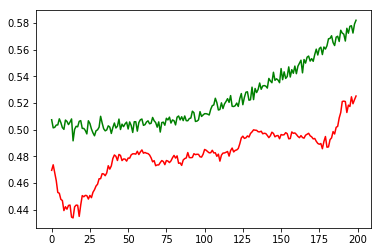

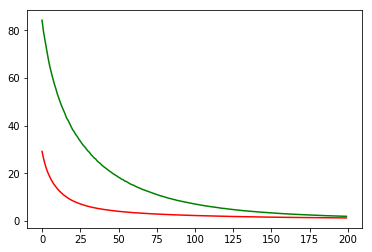

working on d,u and l,le 0.5 128 0.01 0.001


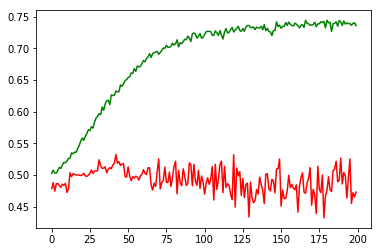

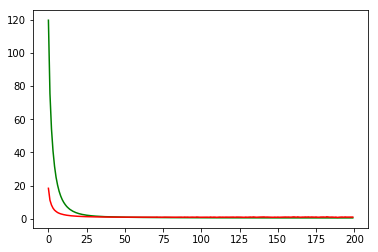

working on d,u and l,le 0.5 128 0.01 0.0001


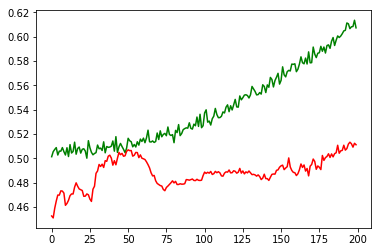

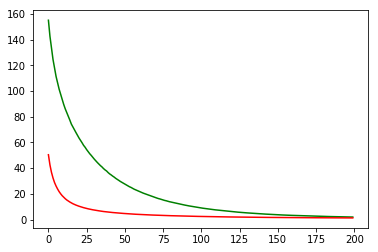

working on d,u and l,le 0.5 256 0.01 0.001


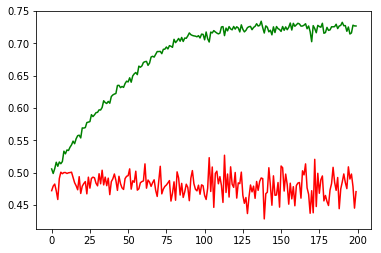

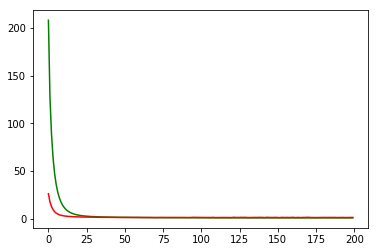

working on d,u and l,le 0.5 256 0.01 0.0001


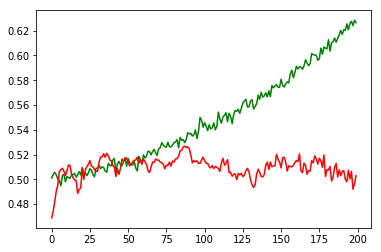

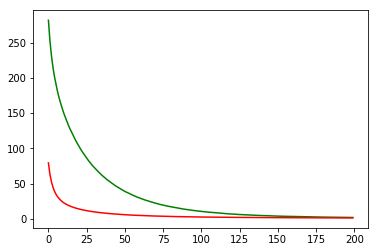

maxd,maxu,maxl,maxle: 0.5 64 0.01 0.0001
Chart for BEST MODEL FOR: NFLX


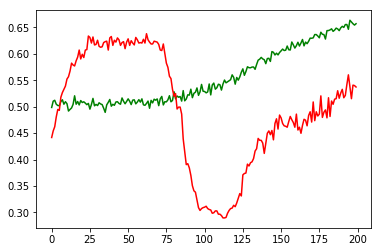

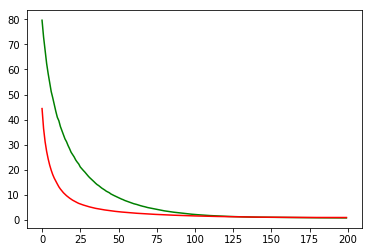

F1,score 0.6492637215528783
G-score: 0.49045815786982366
Accuracy 0.5371024724451476
Window: 140
[[123 174]
 [350 485]]
Vol pos 4.705001644723502
Vol neg 3.9092833850638926
Real Percentage of gain: 82.84778340659777
Percentage of gain: 0.7174704118537186
Total gain: 812.1765062184095
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 67 103]
 [109 181]]
460/460 [==============================] - 0s 38us/step
[0.8964817674263664, 0.5391304347826087]
Percentile:  1
[[ 10  50]
 [147 121]]
328/328 [==============================] - 0s 49us/step
[1.016557827228453, 0.39939024390243905]
Percentile:  2
[[ 20  18]
 [ 71 124]]
233/233 [==============================] - 0s 44us/step
[0.8095639552681231, 0.6180257510729614]
Percentile:  3
[[25  2]
 [23 47]]
97/97 [==============================] - 0s 59us/step
[0.6004706513635891, 0.7422680412371134]
Percentile:  4
[[ 1  0]
 [ 0 11]]
12/12 [==============================] - 0s 95us/step
[0.19175578653812408, 1.0]
00000000000000000

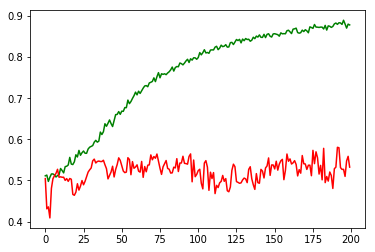

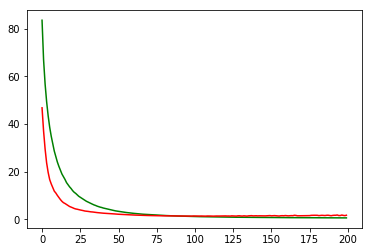

working on d,u and l,le 0.5 64 0.01 0.0001


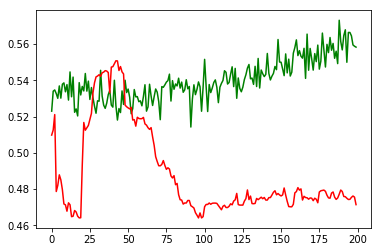

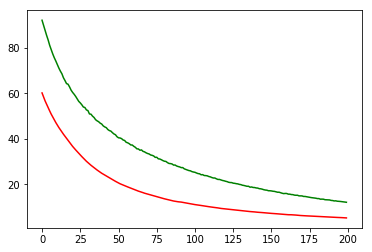

working on d,u and l,le 0.5 128 0.01 0.001


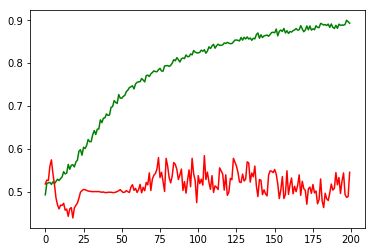

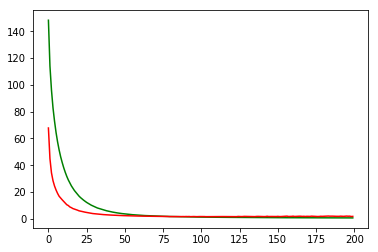

working on d,u and l,le 0.5 128 0.01 0.0001


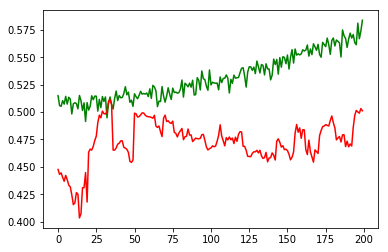

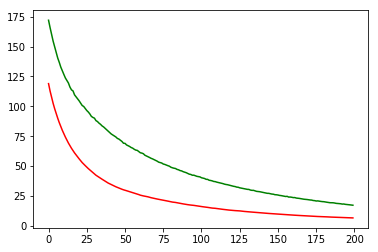

working on d,u and l,le 0.5 256 0.01 0.001


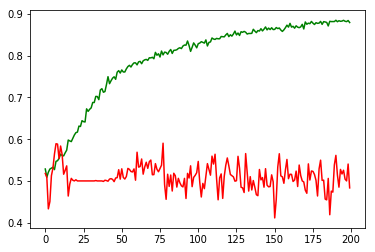

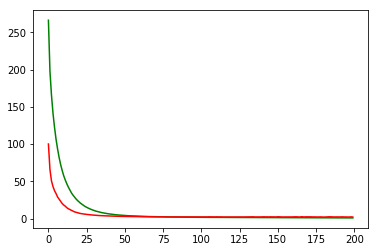

working on d,u and l,le 0.5 256 0.01 0.0001


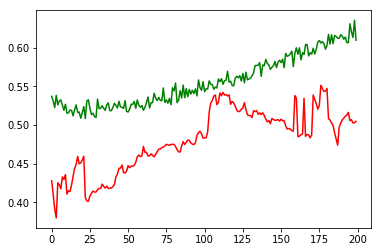

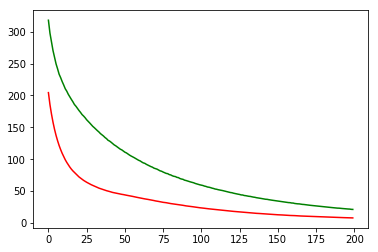

maxd,maxu,maxl,maxle: 0.5 128 0.01 0.001
Chart for BEST MODEL FOR: BKNG


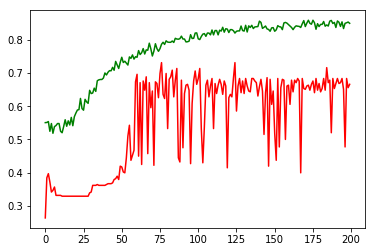

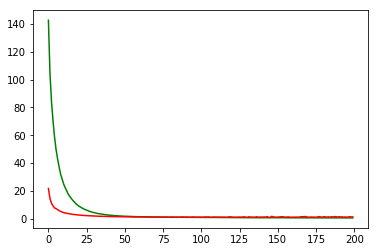

F1,score 0.7956989247311829
G-score: 0.21078234349445923
Accuracy 0.6658291448300807
Window: 140
[[  6 125]
 [  8 259]]
Vol pos 1.4279041450967893
Vol neg 0.6890699481235135
Real Percentage of gain: 217.53127950491702
Percentage of gain: 0.7204731038950297
Total gain: 286.74829535022184
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 6 91]
 [ 5 70]]
172/172 [==============================] - 0s 48us/step
[2.034845778761908, 0.4418604651162791]
Percentile:  1
[[ 0 26]
 [ 0 74]]
100/100 [==============================] - 0s 75us/step
[0.8650624966621399, 0.74]
Percentile:  2
[[ 0  7]
 [ 0 82]]
89/89 [==============================] - 0s 50us/step
[0.507169716143876, 0.9213483226433229]
Percentile:  3
[[ 0  0]
 [ 2 21]]
23/23 [==============================] - 0s 52us/step
[0.42930692434310913, 0.9130434989929199]
Percentile:  4
[[ 0  0]
 [ 1 11]]
12/12 [==============================] - 0s 128us/step
[0.5032001733779907, 0.9166666865348816]
0000000000000000000000000000

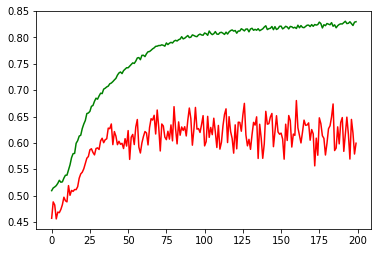

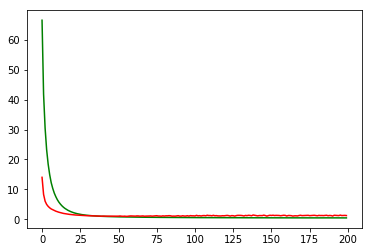

working on d,u and l,le 0.5 64 0.01 0.0001


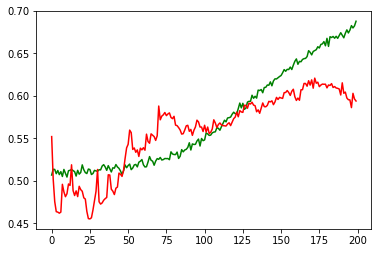

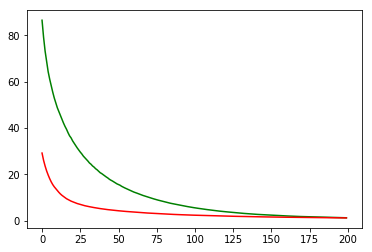

working on d,u and l,le 0.5 128 0.01 0.001


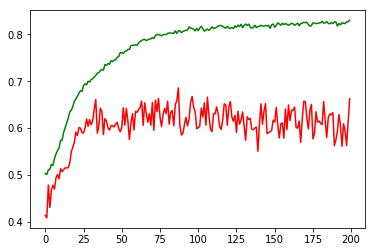

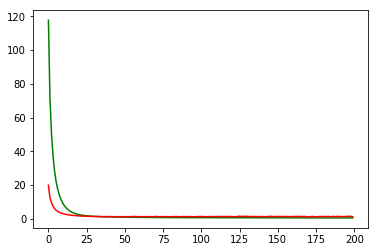

working on d,u and l,le 0.5 128 0.01 0.0001


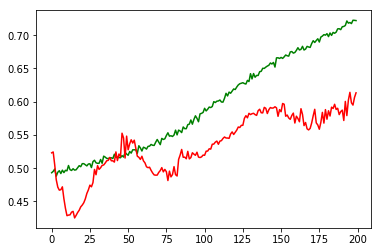

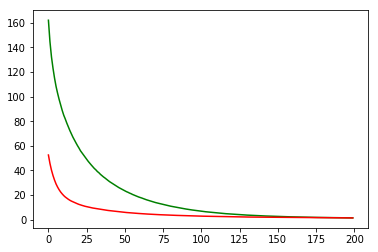

working on d,u and l,le 0.5 256 0.01 0.001


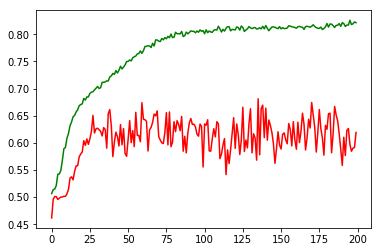

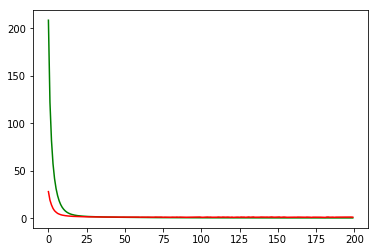

working on d,u and l,le 0.5 256 0.01 0.0001


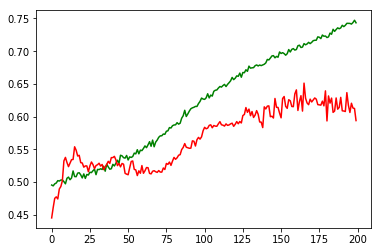

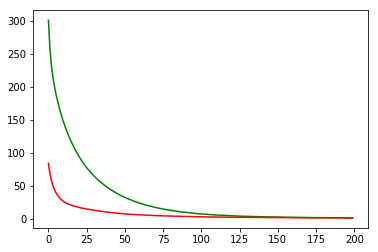

maxd,maxu,maxl,maxle: 0.5 128 0.01 0.001
Chart for BEST MODEL FOR: ADBE


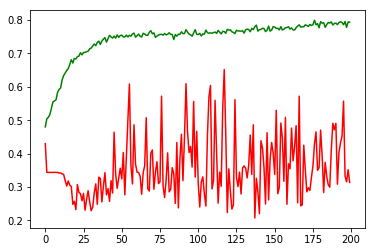

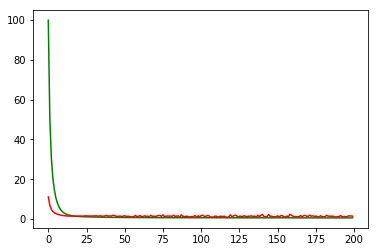

F1,score 0.3804956035171862
G-score: 0.30987925726429155
Accuracy 0.31355181589815023
Window: 140
[[116 272]
 [503 238]]
Vol pos 2.202918888727475
Vol neg 2.7863235549975562
Real Percentage of gain: -203.80663021854244
Percentage of gain: -1.2219375274699558
Total gain: -1379.56746851358
000000000000000000000000000000000000000000000000
Percentile:  0
[[102 175]
 [188  96]]
561/561 [==============================] - 0s 50us/step
[1.2934067556883562, 0.3529411765768354]
Percentile:  1
[[ 14  49]
 [176  85]]
324/324 [==============================] - 0s 56us/step
[1.3247211969193118, 0.3055555555555556]
Percentile:  2
[[ 0 25]
 [85 48]]
158/158 [==============================] - 0s 51us/step
[1.2015818191480032, 0.3037974683544304]
Percentile:  3
[[ 0 23]
 [36  7]]
66/66 [==============================] - 0s 72us/step
[1.6809418056950425, 0.10606060606060606]
Percentile:  4
[[ 0  0]
 [16  2]]
18/18 [==============================] - 0s 124us/step
[1.6974135637283325, 0.1111111119389534]
0

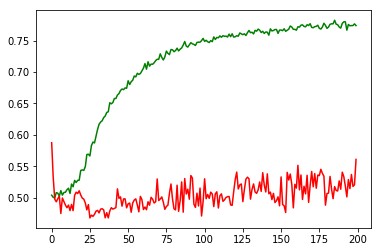

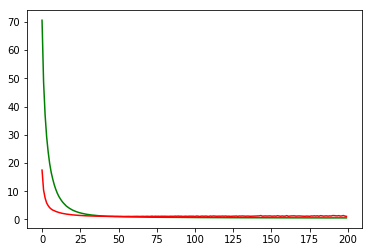

working on d,u and l,le 0.5 64 0.01 0.0001


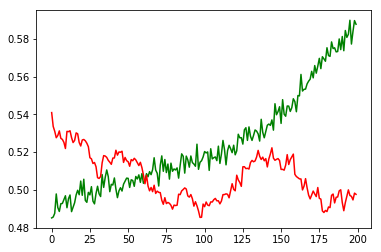

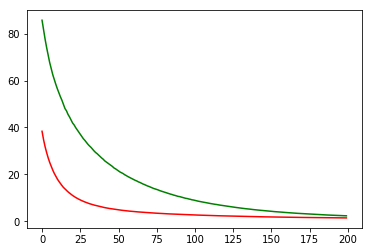

working on d,u and l,le 0.5 128 0.01 0.001


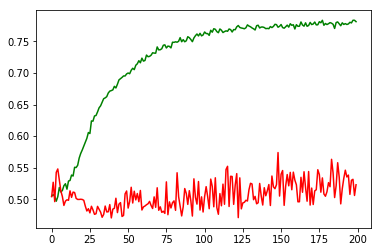

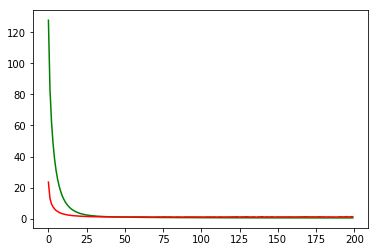

working on d,u and l,le 0.5 128 0.01 0.0001


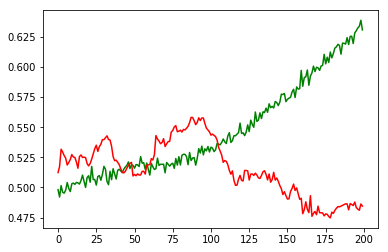

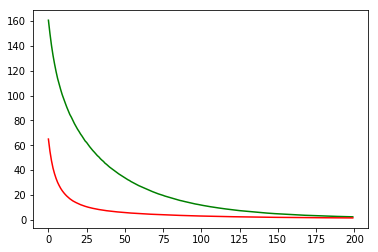

working on d,u and l,le 0.5 256 0.01 0.001


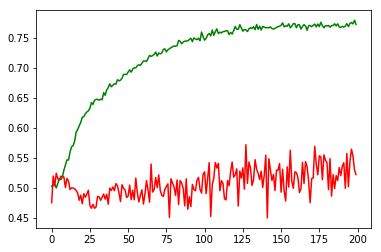

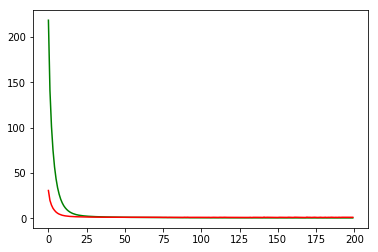

working on d,u and l,le 0.5 256 0.01 0.0001


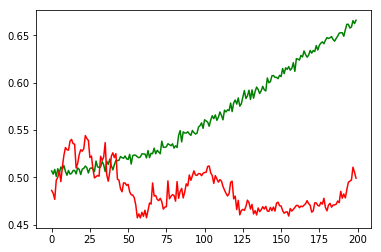

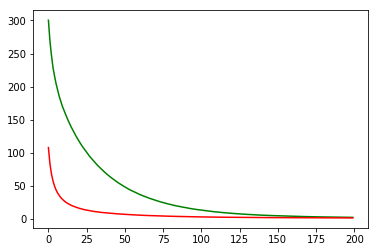

maxd,maxu,maxl,maxle: 0.5 64 0.01 0.001
Chart for BEST MODEL FOR: AMGN


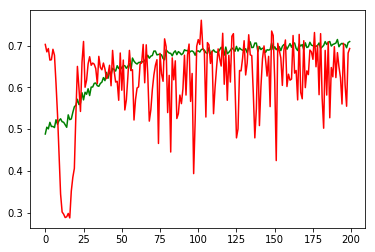

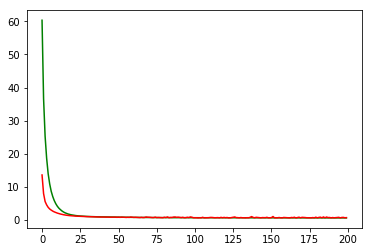

F1,score 0.7876923076923077
G-score: 0.5862687808822084
Accuracy 0.6927871755054776
Window: 140
[[138 182]
 [163 640]]
Vol pos 1.9296257156457441
Vol neg 1.934901011012814
Real Percentage of gain: 177.71892776955985
Percentage of gain: 0.7423935511780659
Total gain: 833.7079579729681
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 82  83]
 [ 84 197]]
446/446 [==============================] - 0s 41us/step
[0.7651449917009593, 0.625560538116592]
Percentile:  1
[[ 33  22]
 [ 45 216]]
316/316 [==============================] - 0s 42us/step
[0.5474910585186149, 0.7879746835443038]
Percentile:  2
[[ 11  15]
 [ 29 159]]
214/214 [==============================] - 0s 51us/step
[0.5539028797751275, 0.794392523364486]
Percentile:  3
[[10 46]
 [ 5 64]]
125/125 [==============================] - 0s 45us/step
[0.6769456949234008, 0.592]
Percentile:  4
[[ 2 15]
 [ 0  3]]
20/20 [==============================] - 0s 62us/step
[0.7510309219360352, 0.25]
000000000000000000000000000000

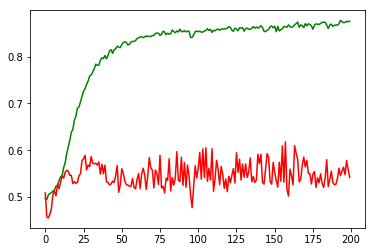

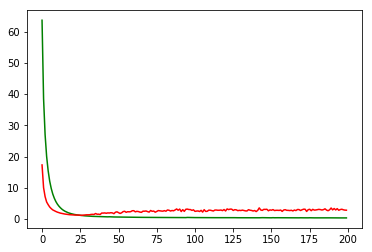

working on d,u and l,le 0.5 64 0.01 0.0001


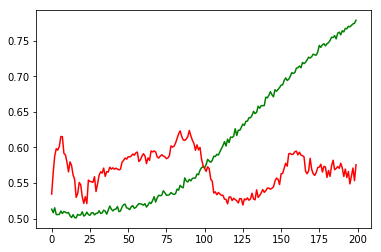

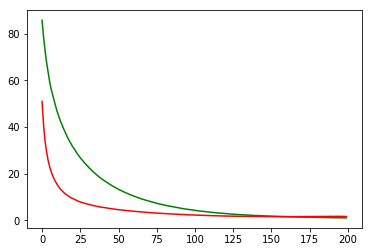

working on d,u and l,le 0.5 128 0.01 0.001


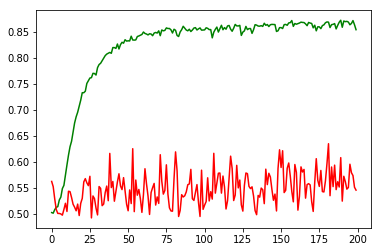

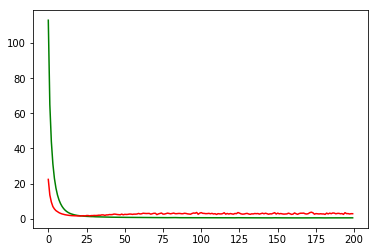

working on d,u and l,le 0.5 128 0.01 0.0001


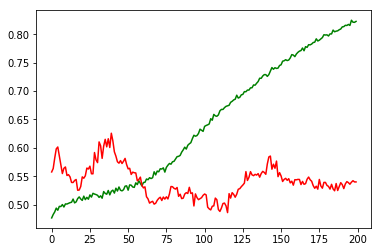

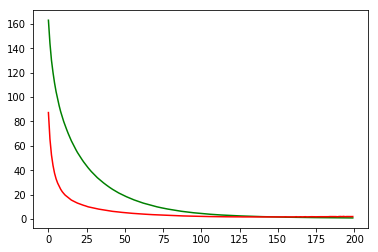

working on d,u and l,le 0.5 256 0.01 0.001


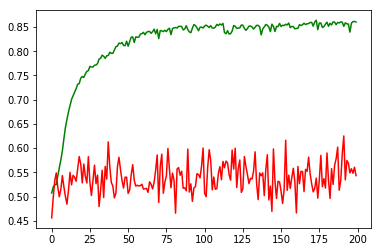

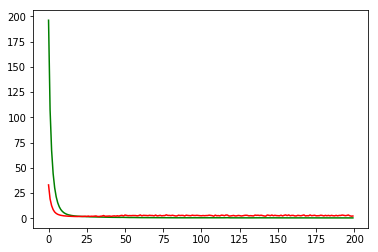

working on d,u and l,le 0.5 256 0.01 0.0001


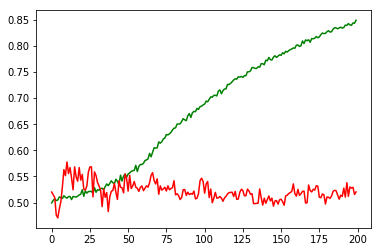

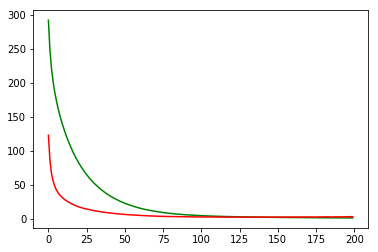

maxd,maxu,maxl,maxle: 0.5 64 0.01 0.0001
Chart for BEST MODEL FOR: TXN


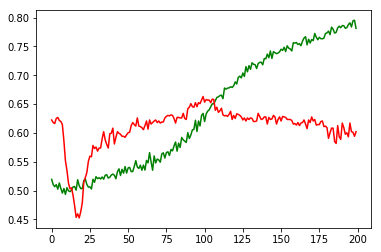

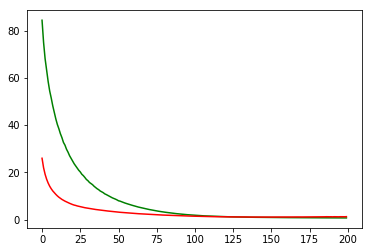

F1,score 0.7031662269129287
G-score: 0.5300395589136099
Accuracy 0.6021220147030002
Window: 140
[[148 220]
 [230 533]]
Vol pos 2.5123056691471457
Vol neg 2.4709327606044447
Real Percentage of gain: 103.07192943878428
Percentage of gain: 0.5295848085032767
Total gain: 598.960418417206
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 80 128]
 [ 50 197]]
455/455 [==============================] - 0s 53us/step
[1.256465815449809, 0.6087912088894583]
Percentile:  1
[[ 68  61]
 [ 68 137]]
334/334 [==============================] - 0s 46us/step
[1.2714366427438701, 0.6137724550898204]
Percentile:  2
[[ 0 14]
 [82 96]]
192/192 [==============================] - 0s 51us/step
[1.0185519605875015, 0.5]
Percentile:  3
[[ 0 10]
 [25 87]]
122/122 [==============================] - 0s 65us/step
[0.7269936604577987, 0.7131147548312047]
Percentile:  4
[[ 0  7]
 [ 5 14]]
26/26 [==============================] - 0s 50us/step
[0.9544237852096558, 0.5384615659713745]
000000000000000000000

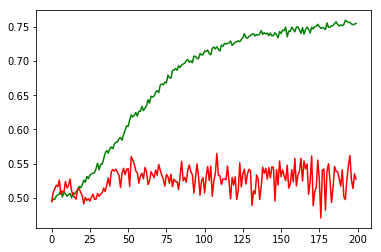

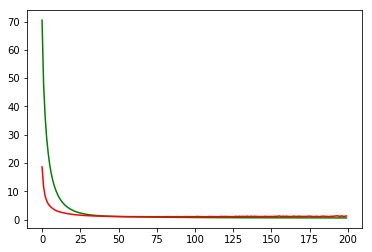

working on d,u and l,le 0.5 64 0.01 0.0001


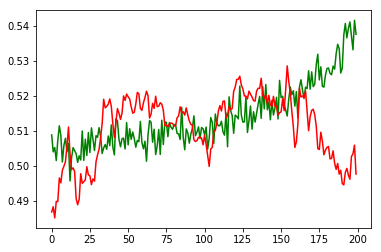

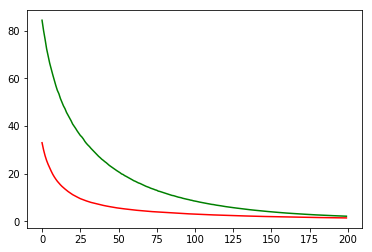

working on d,u and l,le 0.5 128 0.01 0.001


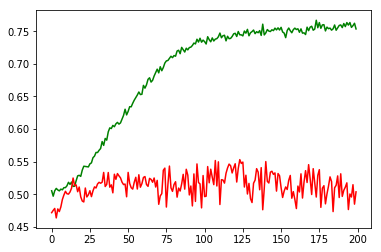

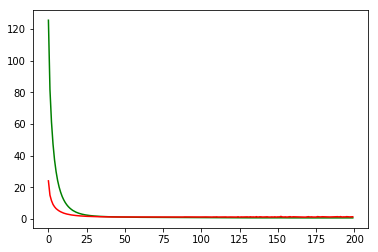

working on d,u and l,le 0.5 128 0.01 0.0001


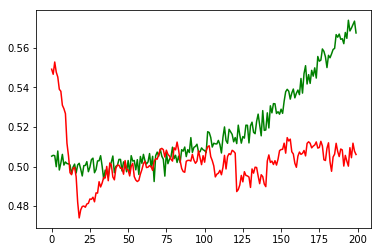

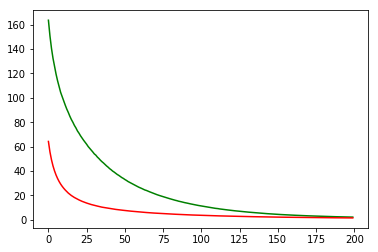

working on d,u and l,le 0.5 256 0.01 0.001


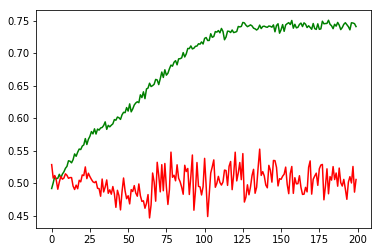

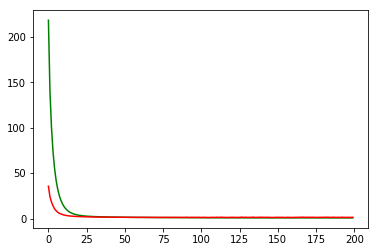

working on d,u and l,le 0.5 256 0.01 0.0001


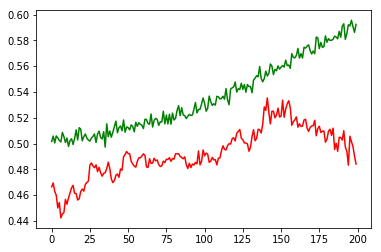

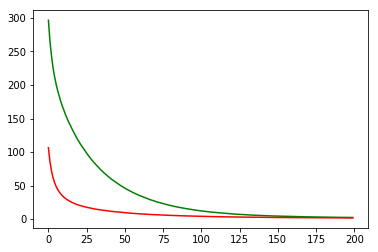

maxd,maxu,maxl,maxle: 0.5 64 0.01 0.001
Chart for BEST MODEL FOR: AVGO


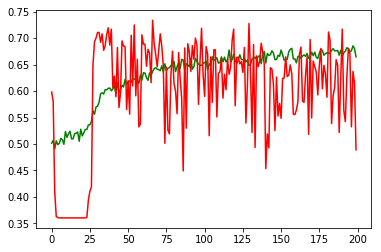

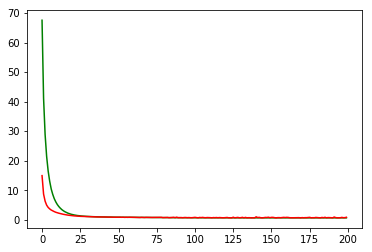

F1,score 0.33944954128440363
G-score: 0.45139082945561165
Accuracy 0.4889086061012671
Window: 140
[[403   3]
 [573 148]]
Vol pos 3.457817570822112
Vol neg 2.957145243265238
Real Percentage of gain: -41.89511793305727
Percentage of gain: 0.17918528962041425
Total gain: 201.94182140220687
000000000000000000000000000000000000000000000000
Percentile:  0
[[198   3]
 [253  21]]
475/475 [==============================] - 0s 58us/step
[0.8213303893490842, 0.4610526314534639]
Percentile:  1
[[104   0]
 [108  42]]
254/254 [==============================] - 0s 35us/step
[0.7268950282119391, 0.5748031499582952]
Percentile:  2
[[ 38   0]
 [180  42]]
260/260 [==============================] - 0s 39us/step
[0.9780195859762338, 0.3076923076923077]
Percentile:  3
[[25  0]
 [31 32]]
88/88 [==============================] - 0s 42us/step
[0.6576405330137773, 0.6477272727272727]
Percentile:  4
[[37  0]
 [ 0 11]]
48/48 [==============================] - 0s 49us/step
[0.3098250726858775, 1.0]
000000000000000

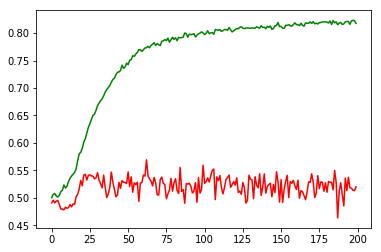

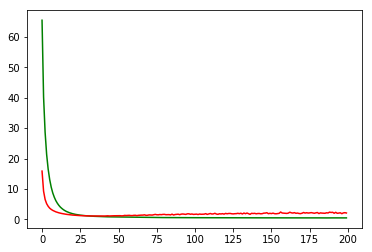

working on d,u and l,le 0.5 64 0.01 0.0001


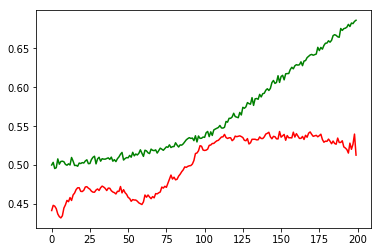

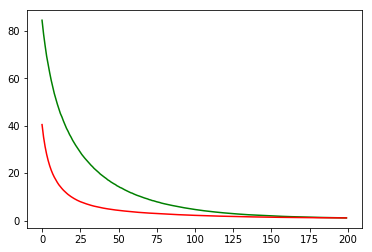

working on d,u and l,le 0.5 128 0.01 0.001


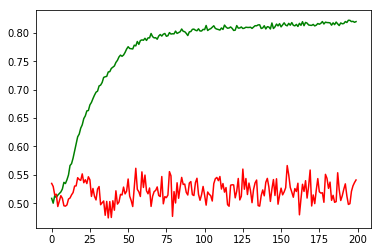

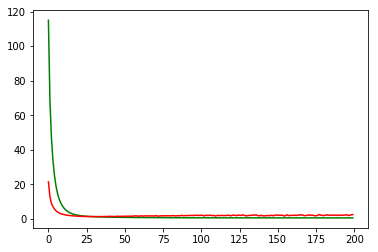

working on d,u and l,le 0.5 128 0.01 0.0001


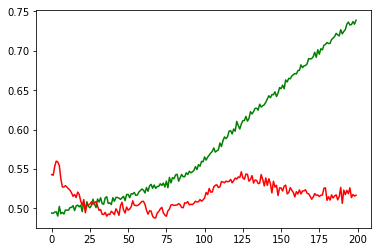

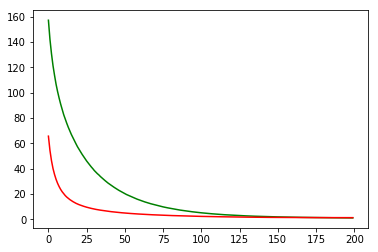

working on d,u and l,le 0.5 256 0.01 0.001


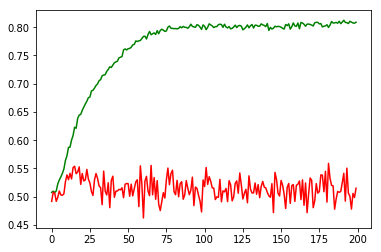

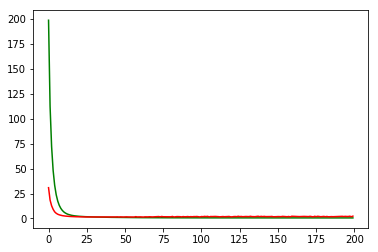

working on d,u and l,le 0.5 256 0.01 0.0001


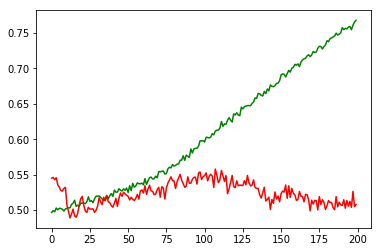

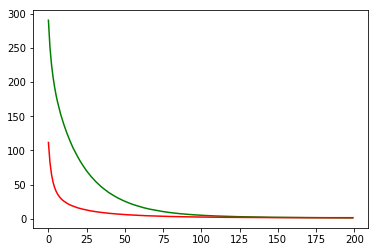

maxd,maxu,maxl,maxle: 0.5 128 0.01 0.001
Chart for BEST MODEL FOR: PYPL


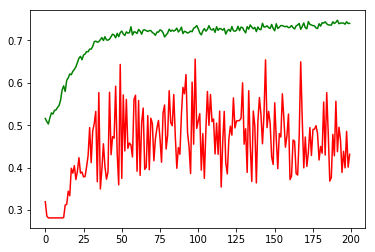

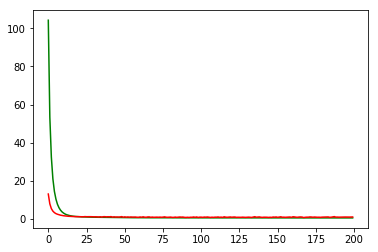

F1,score 0.48722044728434505
G-score: 0.46393979533584684
Accuracy 0.4313551833188249
Window: 140
[[182 136]
 [506 305]]
Vol pos 2.6039757408135924
Vol neg 3.141950912166503
Real Percentage of gain: -60.832683893902065
Percentage of gain: -0.6634156774443536
Total gain: -748.9962998346753
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 79  55]
 [251 194]]
579/579 [==============================] - 0s 37us/step
[0.995850387632538, 0.47150259077651924]
Percentile:  1
[[ 29  22]
 [172  85]]
308/308 [==============================] - 0s 38us/step
[1.047099475736742, 0.37012986974282697]
Percentile:  2
[[69 51]
 [41 23]]
184/184 [==============================] - 0s 38us/step
[1.038528332243795, 0.5000000025915063]
Percentile:  3
[[ 5  8]
 [29  1]]
43/43 [==============================] - 0s 127us/step
[1.4161283165909524, 0.13953488372093023]
Percentile:  4
[[ 0  0]
 [11  1]]
12/12 [==============================] - 0s 123us/step
[1.188671588897705, 0.0833333358168602]
0

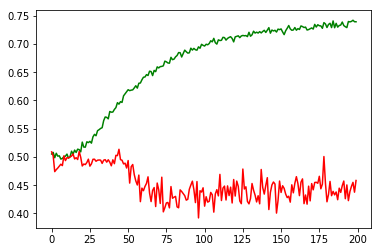

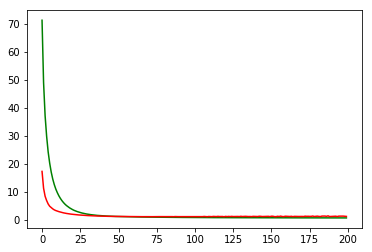

working on d,u and l,le 0.5 64 0.01 0.0001


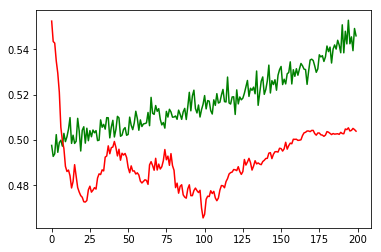

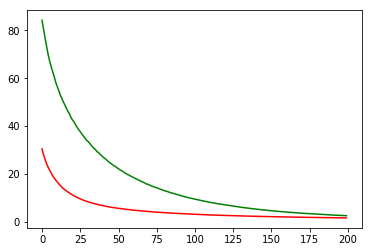

working on d,u and l,le 0.5 128 0.01 0.001


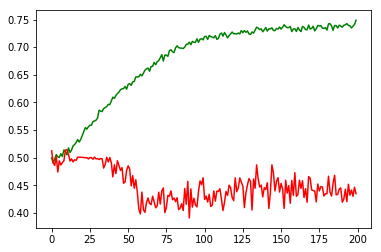

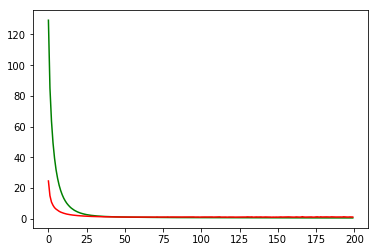

working on d,u and l,le 0.5 128 0.01 0.0001


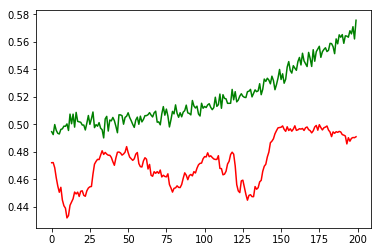

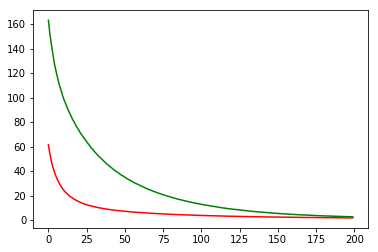

working on d,u and l,le 0.5 256 0.01 0.001


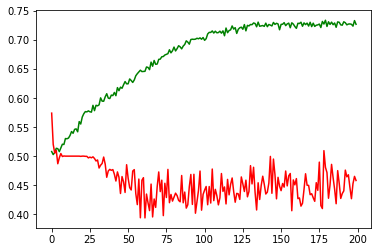

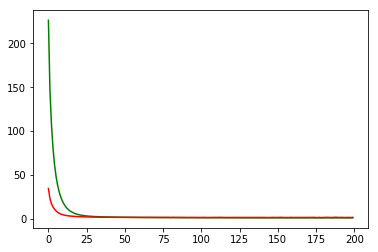

working on d,u and l,le 0.5 256 0.01 0.0001


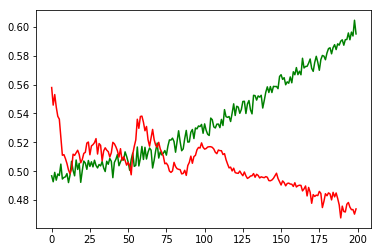

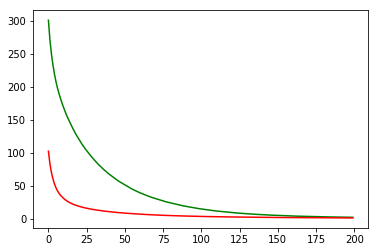

maxd,maxu,maxl,maxle: 0.5 64 0.01 0.0001
Chart for BEST MODEL FOR: GILD


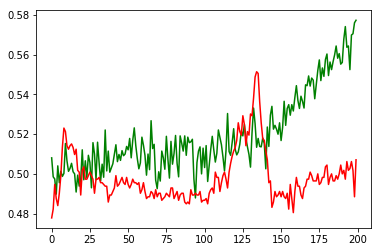

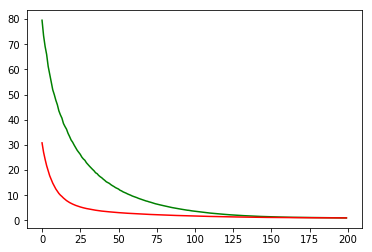

F1,score 0.13664596273291926
G-score: 0.2703867999045623
Accuracy 0.5070921994270162
Window: 140
[[528  54]
 [502  44]]
Vol pos 3.5699388689575704
Vol neg 2.8982806837666044
Real Percentage of gain: 164.4335283936366
Percentage of gain: 0.38170299013253395
Total gain: 430.5609728694983
000000000000000000000000000000000000000000000000
Percentile:  0
[[301  38]
 [235  34]]
608/608 [==============================] - 0s 34us/step
[0.9163927843696192, 0.5509868421052632]
Percentile:  1
[[100   3]
 [195   9]]
307/307 [==============================] - 0s 40us/step
[0.9867081634384801, 0.3550488599348534]
Percentile:  2
[[12  0]
 [69  1]]
82/82 [==============================] - 0s 49us/step
[0.9491505361184841, 0.15853658536585366]
Percentile:  3
[[39  2]
 [ 0  0]]
41/41 [==============================] - 0s 66us/step
[0.8618721874748788, 0.9512195121951219]
Percentile:  4
[[75 11]
 [ 0  0]]
86/86 [==============================] - 0s 47us/step
[0.8737646895785665, 0.872093023255814]
0000000

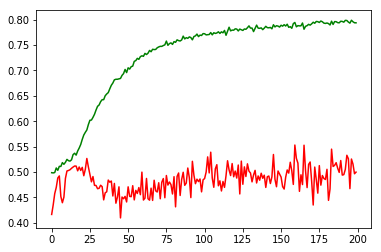

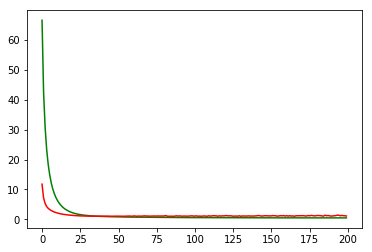

working on d,u and l,le 0.5 64 0.01 0.0001


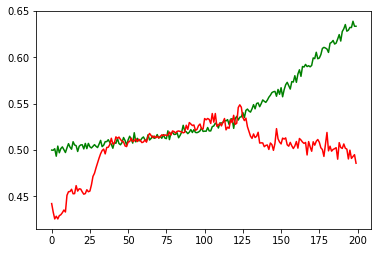

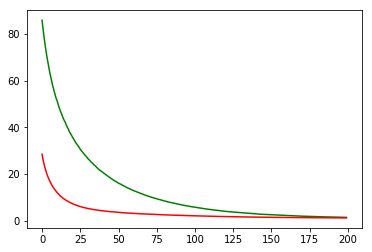

working on d,u and l,le 0.5 128 0.01 0.001


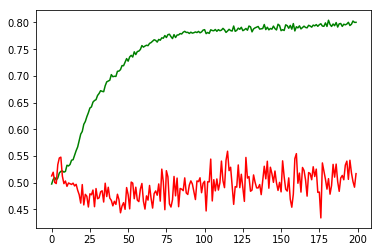

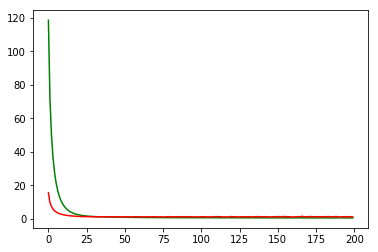

working on d,u and l,le 0.5 128 0.01 0.0001


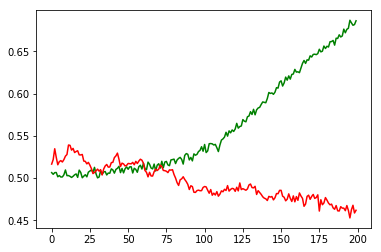

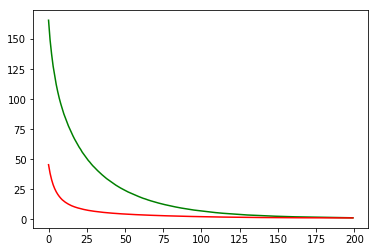

working on d,u and l,le 0.5 256 0.01 0.001


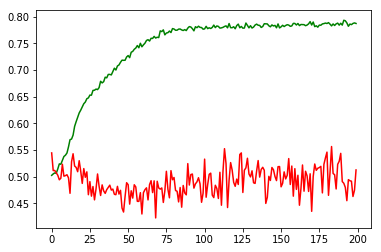

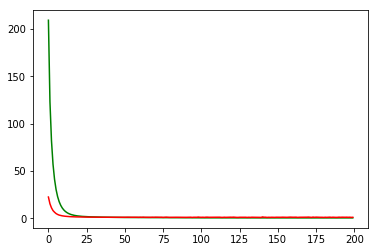

working on d,u and l,le 0.5 256 0.01 0.0001


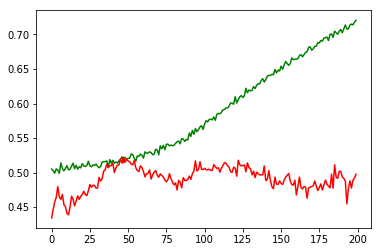

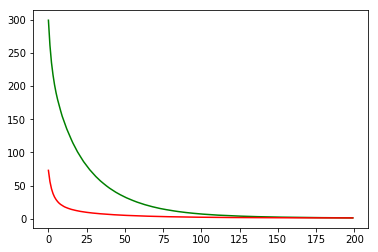

maxd,maxu,maxl,maxle: 0.5 128 0.01 0.001
Chart for BEST MODEL FOR: COST


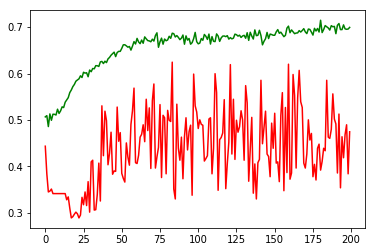

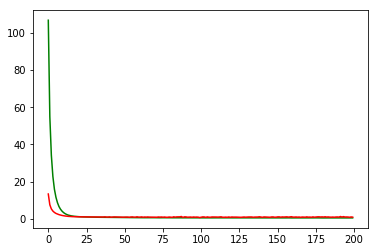

F1,score 0.541795665634675
G-score: 0.4760883660839757
Accuracy 0.4747116243088256
Window: 140
[[185 200]
 [392 350]]
Vol pos 1.4044110240010932
Vol neg 1.3726449687079023
Real Percentage of gain: 45.18015542921108
Percentage of gain: -0.0543442090811831
Total gain: -61.24592363449335
000000000000000000000000000000000000000000000000
Percentile:  0
[[ 78 122]
 [ 95  92]]
387/387 [==============================] - 0s 45us/step
[1.1428698535421407, 0.4392764857881137]
Percentile:  1
[[ 54  50]
 [110  96]]
310/310 [==============================] - 0s 58us/step
[0.9999428149192564, 0.4838709677419355]
Percentile:  2
[[ 43  25]
 [104 101]]
273/273 [==============================] - 0s 63us/step
[0.8776408071483012, 0.5274725282366896]
Percentile:  3
[[ 9  3]
 [38 42]]
92/92 [==============================] - 0s 60us/step
[0.7494534876035608, 0.554347822199697]
Percentile:  4
[[ 0  0]
 [44 19]]
63/63 [==============================] - 0s 46us/step
[0.8794148668410287, 0.3015873001681434]
000

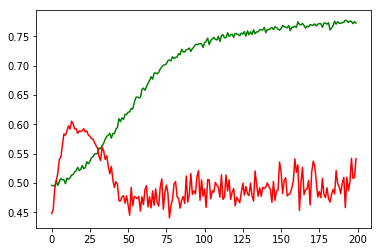

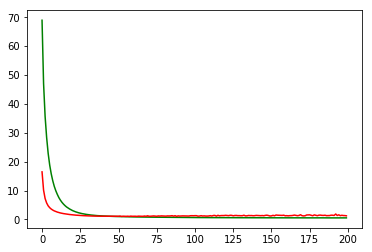

working on d,u and l,le 0.5 64 0.01 0.0001


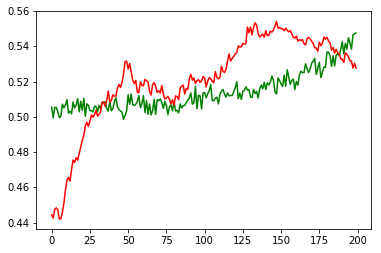

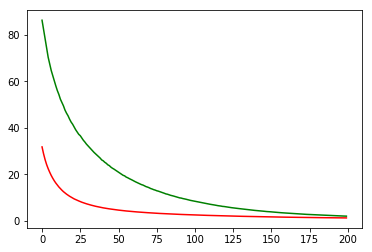

working on d,u and l,le 0.5 128 0.01 0.001


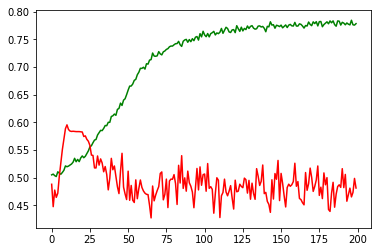

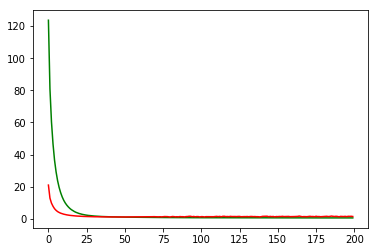

working on d,u and l,le 0.5 128 0.01 0.0001


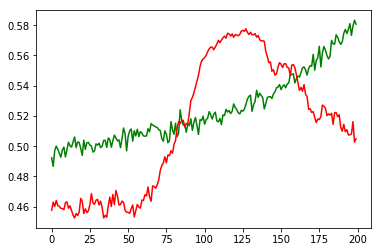

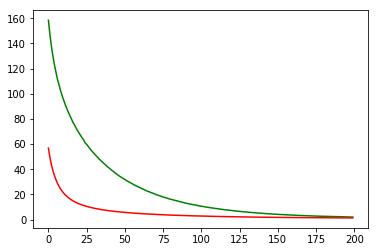

working on d,u and l,le 0.5 256 0.01 0.001


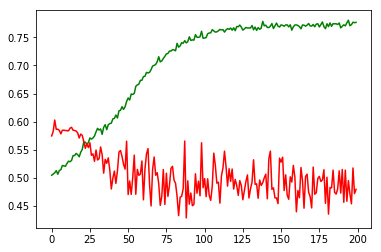

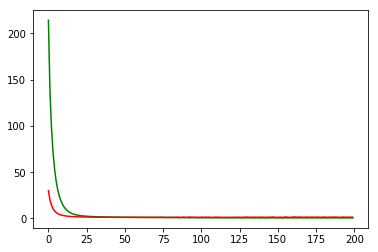

working on d,u and l,le 0.5 256 0.01 0.0001


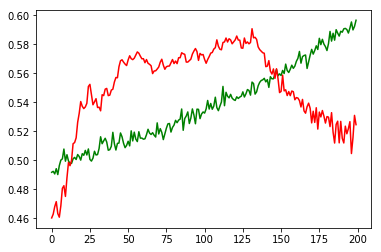

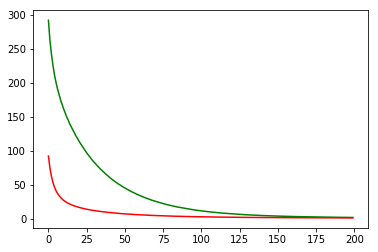

maxd,maxu,maxl,maxle: 0.5 64 0.01 0.001
Chart for BEST MODEL FOR: QCOM


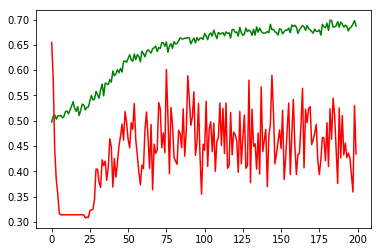

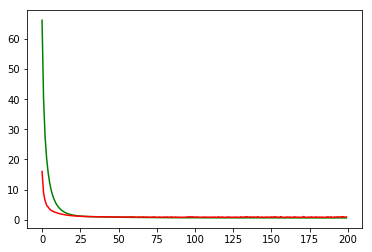

F1,score 0.452054794520548
G-score: 0.46641214961258154
Accuracy 0.4341290908298273
Window: 140
[[227 128]
 [512 264]]
Vol pos 3.5509939799968633
Vol neg 3.1989395023822196
Real Percentage of gain: -41.226759927797794
Percentage of gain: -0.26859702683126513
Total gain: -303.78323734616083
000000000000000000000000000000000000000000000000
Percentile:  0
[[148  82]
 [207  92]]
529/529 [==============================] - 0s 48us/step
[0.9586561327845928, 0.4536862007724315]
Percentile:  1
[[ 20  28]
 [197  99]]
344/344 [==============================] - 0s 45us/step
[0.9829997295557067, 0.3459302318650623]
Percentile:  2
[[16  2]
 [57 33]]
108/108 [==============================] - 0s 38us/step
[0.7261823393680431, 0.45370370149612427]
Percentile:  3
[[12  0]
 [35 33]]
80/80 [==============================] - 0s 71us/step
[0.6785526752471924, 0.5625]
Percentile:  4
[[31 15]
 [16  6]]
68/68 [==============================] - 0s 78us/step
[0.740717375979704, 0.5441176470588235]
0000000000000

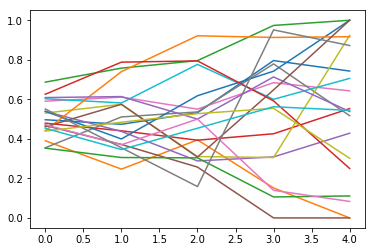

Ecco la matrice generale:
[[4132. 3344.]
 [7282. 6623.]]
Ecco le matrici per percentile
Percentile : 0
[[2343. 1939.]
 [2882. 2407.]]
Percentile : 1
[[ 903.  709.]
 [2547. 2111.]]
Percentile : 2
[[ 429.  396.]
 [1239. 1239.]]
Percentile : 3
[[241. 208.]
 [415. 619.]]
Percentile : 4
[[254. 133.]
 [230. 229.]]


In [4]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')
o=0
accstocksresults=[]
f1stocksresults=[]
f1scoreresults=[]
aucresults=[]
chartlist=[]
gainlist=[]
pricegainlist=[]
totalconfusion=np.zeros((2,2))
confusionlist=[]
for con in range(0,5):
    confusionlist.append(np.zeros((2,2)))

for price in prices:
    #print('New price[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[[]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]]')
    
   
    print('Working on...',files[o])
    
    senttemp=sentiment[o]
    senttemp=np.nan_to_num(np.asarray(senttemp, dtype=float))
    
    xtemp=price
    o+=1
    xtemp=np.nan_to_num(np.asarray(xtemp, dtype=float))
    
    #print(xtemp)
    accintime=[]
    trendwindowtime=[140]
    f1total=[]
    acctotal=[]
    auctotal=[]
    percfinal=[]
    f1scoretotal=[]
    percpostotal=[]
    percnegtotal=[]
    for t in trendwindowtime:
        #1
    #label because of the maket and append values without data
    #simo theroy past trend
        
        x=[]
        y=[]
        percentage=[]
        
        yvolatility=[]
        yprice=[]
        #print('============================================================')
        #print('Working on window:',t)
        #print(len(xtemp))
        ##QUI C E L'UNICO APPUNTO GUARDA SE CON +1 CAMBIA
        
        for i in range(0,len(price)-t-1):
            s=np.sign(price.iloc[i+t+1]['close']-price.iloc[i+1]['open'])
            percentage.append((100*(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open']) 
            if(s==-1):
                y.append(0)
            else:
                y.append(1)
            yvolatility.append((100*abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))/price.iloc[i+1]['open'])
            yprice.append(abs(price.iloc[i+t+1]['close']-price.iloc[i+1]['open']))
            x.append(senttemp[i])
        
        y=np.array(y)
        x=np.array(x)
        scaler = MinMaxScaler() 
        scaler.fit(x)
        MinMaxScaler(copy=True, feature_range=(0, 1))
        x=scaler.transform(x)
        yvolatility=np.array(yvolatility)
       
        permindex=range(0,len(x))
        #permindex=np.random.permutation(permindex)
        train=0.8
        nt=math.ceil(len(x)*train)
        trainvalindex=permindex[0:nt]
        testindex=permindex[nt:]
        x_tv=[]
        y_tv=[]
        x_test=[]
        y_test=[]
        x_tv=x[trainvalindex]
        y_tv=y[trainvalindex]
        x_test=x[testindex]
        y_test=y[testindex]
        yvolatilitytest=yvolatility[testindex]
        #create structure for percentile valuation
        distribution=[]
        print(max(yvolatilitytest))
        print(min(yvolatilitytest))
        step=(max(yvolatilitytest)-min(yvolatilitytest))/5
        for v in range(0,5):
            pindexes=[]
            for r in range(0,len(y_test)):
                if(yvolatilitytest[r]<min(yvolatilitytest)+step+step*v and yvolatilitytest[r]>min(yvolatilitytest)+step*v):
                    pindexes.append(r)
            distribution.append(pindexes)
    


        lspace=[0.01]
        dropspace=[0.5]
        uspace=[64,128,256]
        learnspace=[0.001,0.0001]
        bestsvm=None
        bestca=[]
        bestcl=[]
        maxacc=0
        cvacc=0
        maxu=0
        maxl=0
        maxd=0
        maxle=0
        #print('Model Selection...')
        #model selection
        cvacc=0
        totu=0
        for d in dropspace:
            for u in uspace:
                #print()
                for l in lspace:
                    for le in learnspace:
                    
                   
                        print('=========================================================')
                        print('working on d,u and l,le',d,u,l,le)

                        cvacclist=[]
                        #faccio cross validation
                        #start with 40% as train and 10% for validation and then i move in percentege
                        # 0-40 40-50
                        # 0-50 50-60
                        # 0-60 60-70 
                        #etc test set is completely external i do in some way error extimation changin the ticker
                        trainpoint=math.floor(len(x_tv)*0.40)
                        dimval=math.floor(trainpoint*0.25)
                        endval=trainpoint+dimval
                        
                        for i in range(0,6):
                            model=buildModel(l,u,d,le)
                            #print('-----')
                            x_train=x_tv[0:trainpoint]
                            y_train=y_tv[0:trainpoint]
                            x_val=x_tv[trainpoint:endval]
                            y_val=y_tv[trainpoint:endval]

                            trainpoint=trainpoint+dimval
                            endval=endval+dimval

                            x_train,y_train=smote(x_train,y_train)
                            if(sum(y_val)+6<len(x_val) and sum(y_val)>6):
                                x_val,y_val=smote(x_val,y_val)
                            else:
                                totu=totu+1

                            history=model.fit(x_train, y_train, epochs = 200,batch_size =128, verbose=0, validation_data=(x_val, y_val),
                                              shuffle=True)
                            prediction=model.predict(x_val, batch_size=128, verbose=0)
                            for el in range(0,len(prediction)):
                                if(prediction[el]>0.5):
                                    prediction[el]=1
                                else:
                                    prediction[el]=0



                            if(i==0):
                                meanhvl=np.asarray(history.history['val_loss'])
                                meanhva=np.asarray(history.history['val_acc'])
                                meanhl=np.asarray(history.history['loss'])
                                meanha=np.asarray(history.history['acc'])

                            else:
                                meanhvl=np.add(meanhvl,history.history['val_loss'])
                                meanhva=np.add(meanhva,history.history['val_acc'])
                                meanha=np.add(meanha,history.history['acc'])
                                meanhl=np.add(meanhl,history.history['loss'])
                           
                            #i take the last one
                            #maxAcc=history.history['val_acc'][len(history.history['val_acc'])-1]
                            #USING G SCORE AS MODEL SELECTION METRIC
                            maxAcc=history.history['val_acc'][len(history.history['val_acc'])-1]
                            cvacclist.append(maxAcc)
                            model=None
                            history=None
                            del model
                            del history
                            gc.collect()
                            tf.reset_default_graph()
                            K.clear_session()

                        cvacc=sum(cvacclist)/len(cvacclist)
                        if(cvacc>maxacc):
                            maxacc=cvacc
                            maxu=u
                            maxl=l
                            maxle=le
                            maxd=d


                        meanhvl=meanhvl/6
                        meanhva=meanhva/6
                        meanhl=meanhl/6
                        meanha=meanha/6

                        plt.plot(meanha,'g')
                        plt.plot(meanhva,'r')
                        plt.show()
                        plt.plot(meanhl,'g')
                        plt.plot(meanhvl,'r')
                        plt.show()

                        print('=========================================================')
        model=buildModel(maxl,maxu,maxd,maxle)
        x_tv,y_tv=smote(x_tv,y_tv)
        history=model.fit(x_tv, y_tv, epochs =200,batch_size =128, verbose=0, validation_data=(x_test, y_test),
                                          shuffle=True)
        prediction=model.predict(x_test, batch_size=128, verbose=0)
        for el in range(0,len(prediction)):
            if(prediction[el]>0.5):
                prediction[el]=1
            else:
                prediction[el]=0
            
        
        
        print('=========================================================')
        print('=========================================================')
        print('=========================================================')
        print('=========================================================')
        print('maxd,maxu,maxl,maxle:',maxd,maxu,maxl,maxle)
        print('Chart for BEST MODEL FOR:',files[o-1])
        plt.plot(history.history['acc'],'g')
        plt.plot(history.history['val_acc'],'r')
        plt.show()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        plt.show()
        acctotal.append(history.history['val_acc'][len(history.history['val_acc'])-1])
        confmatrix=confusion_matrix(y_test, prediction)
        totalconfusion=totalconfusion+confmatrix
        volr=[]
        voln=[]
        pricegain=0
        for j in range(0,len(x_test)):
            if(y_test[j]==prediction[j]):
                volr.append(yvolatilitytest[j])
                pricegain=pricegain+yprice[j]
            else:
                voln.append(yvolatilitytest[j])
                pricegain=pricegain-yprice[j]
        
        CM = f1_score(y_test, prediction)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        auc=metrics.auc(fpr, tpr)
        valueacc=geometric_mean_score(y_test, prediction)
        
        print('F1,score',CM)
        print('G-score:',valueacc)
        realacc=history.history['val_acc'][len(history.history['val_acc'])-1]
        accstocksresults.append(realacc)
        print('Accuracy',realacc)
        print('Window:',t)
        print(confmatrix)
        print('Vol pos',sum(volr)/len(volr))
        print('Vol neg',sum(voln)/len(voln))
        percnegtotal.append(sum(volr)/len(volr))
        percpostotal.append(sum(voln)/len(voln))
        #build structure to plot distribution onver percentile
        chart=np.zeros(5)
        for r in range(0,len(y_test)):
            for v in range(0,5):
                if(yvolatilitytest[r]<min(yvolatility)+step+step*v and yvolatilitytest[r]>min(yvolatility)+step*v):
                    chart[v]+=1
        #plt.plot(chart)
        #plt.show()
        print('Real Percentage of gain:',(pricegain*100)/(sum(price.iloc[1:6]['open'])))
        pricegainlist.append((pricegain*100)/(sum(price.iloc[1:6]['open'])))
        print('Percentage of gain:',(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        print('Total gain:',len(y_test)*(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        gainlist.append(len(y_test)*(sum(volr)-sum(voln))/(len(volr)+len(voln)))
        print('000000000000000000000000000000000000000000000000')
        #performances for each percentile
        chartscore=[]
        for g in range(0,len(distribution)):
            print('Percentile: ',g)
            tempscore=0
            if(len(distribution[g])>0):
                predictionp=model.predict(x_test[distribution[g]])
                for el in range(0,len(predictionp)):
                    if(predictionp[el]>0.5):
                        predictionp[el]=1
                    else:
                        predictionp[el]=0
                tempmatrix=confusion_matrix(y_test[distribution[g]], predictionp)
                confusionlist[g]=confusionlist[g]+tempmatrix
                print(tempmatrix)
                print(model.evaluate(x_test[distribution[g]],y_test[distribution[g]]))
                tempscore=model.evaluate(x_test[distribution[g]],y_test[distribution[g]], verbose=0)
            chartscore.append(tempscore[1])    
        chartlist.append(chartscore)
        print('000000000000000000000000000000000000000000000000')
print('Mean acc over portfolio:',sum(accstocksresults)/len(accstocksresults))
print('Mean gain over portfolio : ', sum(gainlist)/len(gainlist))
print('Real mean gain over portfolio',sum(pricegainlist)/len(pricegainlist))
#print all the accuracy varing the percentile
for st in range(0,len(chartlist)):
    plt.plot(chartlist[st])
plt.show()
print('Ecco la matrice generale:')
print(totalconfusion)
print('Ecco le matrici per percentile')
for i in range(0,len(confusionlist)):
    print('Percentile :',i)
    print(confusionlist[i])        

            

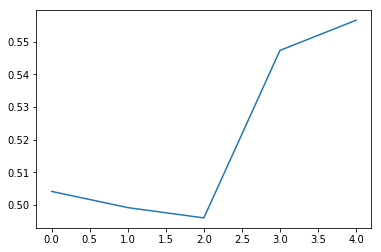

In [5]:
tot=np.zeros(5)
for st in range(0,len(chartlist)):
    tot=chartlist[st]+tot
    
tot=tot/len(chartlist)
plt.plot(tot)
plt.show()

In [6]:
l=[]
for i in range(0,5):
    l.append(np.zeros((2,2)))
l[0]=l[0]+confmatrix
print(l[0])
print('[[[]]]')
z=np.zeros((2,2))
print(confmatrix)
z=z+confmatrix
print(z)

[[227. 128.]
 [512. 264.]]
[[[]]]
[[227 128]
 [512 264]]
[[227. 128.]
 [512. 264.]]


In [7]:
#print('ACCURACY on val:',maxacc)
        print('Test')
        model=buildModel(maxl,maxu)
        x_tv,y_tv=smote(x_tv,y_tv)
        history=model.fit(x_tv, y_tv, epochs=20,shuffle=False, verbose=2,batch_size=100,validation_data=(x_test,y_test))
        plt.plot(history.history['acc'],'g')
        plt.plot(history.history['val_acc'],'r')
        plt.show()
        plt.plot(history.history['loss'],'g')
        plt.plot(history.history['val_loss'],'r')
        plt.show()
        
        e=findMaxAccStep(history.history['val_acc'],history.history['val_loss'])
        model.fit(x_tv, y_tv, epochs=e,shuffle=False, verbose=0,batch_size=10)
        prediction=model.predict( x_test, batch_size=10, verbose=0, steps=None)
        confmatrix=confusion_matrix(y_test, prediction)
        print('Window:',t)
        print(confmatrix)
        CM = f1_score(y_test, prediction)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, prediction)
        auc=metrics.auc(fpr, tpr)
        valueacc=rbf_svm.score(x_test,y_test)
        #print('Accuracy on TEST set:',testacc
        
        print('F1,score',CM)
        print('Accuracy:',valueacc)
        f1scoretotal.append(CM)
        f1total.append(totu)
        acctotal.append(valueacc)
        auctotal.append(auc)
    print(f1total)
    print(acctotal)
    print('accuracy')
    print('accuracy')
    f1total=normalize(np.asarray(f1total).reshape(-1,1),axis=0,norm='max')
    plt.plot(trendwindowtime,acctotal,'g')
    plt.plot(trendwindowtime,f1total,'r')
    plt.show()
    f1scoreresults.append(f1scoretotal)
    accstocksresults.append(acctotal)
    f1stocksresults.append(f1total)
    aucresults.append(auctotal)
for p in accstocksresults:
    plt.plot(p)
plt.show()

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 31)

In [ ]:
tempacc=accstocksresults

In [ ]:
import operator
t=[0,0,0]
for i in range(0,len(tempacc)):
    t=np.add(t,tempacc[i])
print(t)
print(t/len(tempacc))

In [ ]:
Working on... AAPL
/home/andrea/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
Window: 2
[[249  81]
 [263 107]]
F1,score 0.38351254480286734
Accuracy: 0.5085714285714286
Window: 4
[[  0 323]
 [  0 376]]
F1,score 0.6995348837209303
Accuracy: 0.5379113018597997
Window: 6
[[243  85]
 [271 100]]
F1,score 0.35971223021582727
Accuracy: 0.4907010014306152
Window: 10
[[247  77]
 [234 140]]
F1,score 0.4737732656514382
Accuracy: 0.5544412607449857
Window: 16
[[257  67]
 [259 114]]
F1,score 0.4115523465703971
Accuracy: 0.5322812051649928
Window: 24
[[210  96]
 [253 136]]
F1,score 0.43800322061191627
Accuracy: 0.497841726618705
Window: 32
[[192 107]
 [217 178]]
F1,score 0.5235294117647058
Accuracy: 0.5331412103746398
Window: 42
[[219  76]
 [235 162]]
F1,score 0.5102362204724409
Accuracy: 0.5505780346820809
Window: 56
[[245  62]
 [227 155]]
F1,score 0.5175292153589315
Accuracy: 0.5805515239477503
Window: 66
[[  3 316]
 [  0 368]]
F1,score 0.6996197718631179
Accuracy: 0.5400291120815138
Window: 87
[[272  61]
 [197 153]]
F1,score 0.5425531914893618
Accuracy: 0.6222547584187409
Window: 100
[[188 135]
 [138 219]]
F1,score 0.6160337552742615
Accuracy: 0.5985294117647059
Window: 112
[[188 129]
 [134 227]]
F1,score 0.6331938633193863
Accuracy: 0.612094395280236
Window: 125
[[266  46]
 [236 127]]
F1,score 0.47388059701492535
Accuracy: 0.5822222222222222
Window: 140
[[315  24]
 [258  75]]
F1,score 0.3472222222222222
Accuracy: 0.5803571428571429
Window: 160
[[329  46]
 [172 121]]
F1,score 0.5260869565217392
Accuracy: 0.6736526946107785
Window: 175
[[365  15]
 [227  58]]
F1,score 0.3240223463687151
Accuracy: 0.6360902255639098
Window: 190
[[123 236]
 [ 57 246]]
F1,score 0.6267515923566879
Accuracy: 0.5574018126888217
Window: 205
[[ 27 314]
 [ 34 284]]
F1,score 0.6200873362445416
Accuracy: 0.47192716236722304
Window: 220
[[312   9]
 [294  41]]
F1,score 0.21298701298701297
Accuracy: 0.538109756097561
Window: 245
[[  0 260]
 [  0 391]]
F1,score 0.7504798464491362
Accuracy: 0.6006144393241167
Window: 260
[[246   7]
 [291 104]]
F1,score 0.41106719367588934
Accuracy: 0.5401234567901234
Window: 300
[[ 29 228]
 [ 48 335]]
F1,score 0.7082452431289641
Accuracy: 0.56875
Window: 350
[[127 109]
 [124 270]]
F1,score 0.6985769728331177
Accuracy: 0.6301587301587301
Window: 400
[[ 12 248]
 [ 17 343]]
F1,score 0.7213459516298634
Accuracy: 0.5725806451612904
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 15, 15, 15, 15, 15, 15, 30, 30, 30, 30, 30, 30, 45, 45, 45]
[0.5085714285714286, 0.5379113018597997, 0.4907010014306152, 0.5544412607449857, 0.5322812051649928, 0.497841726618705, 0.5331412103746398, 0.5505780346820809, 0.5805515239477503, 0.5400291120815138, 0.6222547584187409, 0.5985294117647059, 0.612094395280236, 0.5822222222222222, 0.5803571428571429, 0.6736526946107785, 0.6360902255639098, 0.5574018126888217, 0.47192716236722304, 0.538109756097561, 0.6006144393241167, 0.5401234567901234, 0.56875, 0.6301587301587301, 0.5725806451612904]
accuracy
accuracy
#old with f1 score in model selection
aapl=[0.5213675213675214, 0.5327635327635327, 0.5242165242165242, 0.5278174037089871, 0.5228571428571429, 0.5444126074498568, 0.5589080459770115, 0.5662824207492796, 0.5433526011560693, 0.5130434782608696, 0.5883211678832116, 0.6881405563689604, 0.6852941176470588, 0.5353982300884956, 0.5422222222222223, 0.4157973174366617, 0.4041916167664671, 0.44511278195488724, 0.48338368580060426, 0.5128983308042488, 0.6131498470948012, 0.6236559139784946, 0.6003110419906688, 0.627172195892575, 0.5826645264847512]
adbe=[0.5498575498575499, 0.5698005698005698, 0.5783475783475783, 0.6148359486447932, 0.6414285714285715, 0.6575931232091691, 0.6752873563218391, 0.6772334293948127, 0.6734104046242775, 0.6652173913043479, 0.6802919708029197, 0.6881405563689604, 0.7147058823529412, 0.7684365781710915, 0.7911111111111111, 0.8002980625931445, 0.7754491017964071, 0.7894736842105263, 0.8187311178247734, 0.8634294385432474, 0.8929663608562691, 0.9139784946236559, 0.9891135303265941, 0.9936808846761453, 1.0]
adi=[0.51994301994302, 0.5341880341880342, 0.550641940085592, 0.5428571428571428, 0.5464949928469242, 0.5544412607449857, 0.5502873563218391, 0.5749279538904899, 0.6034732272069464, 0.5892597968069666, 0.5883211678832116, 0.5791788856304986, 0.5441176470588235, 0.518463810930576, 0.46735905044510384, 0.45671641791044776, 0.4587706146926537, 0.4879518072289157, 0.5128593040847201, 0.5486322188449848, 0.4946401225114854, 0.5261538461538462, 0.557632398753894, 0.7215189873417721, 0.6270096463022508]
googl=[0.496551724137931, 0.5189655172413793, 0.5413793103448276, 0.538860103626943, 0.5657439446366782, 0.5538194444444444, 0.5679442508710801, 0.5856643356643356, 0.5421052631578948, 0.5475352112676056, 0.5808170515097691, 0.5508021390374331, 0.517921146953405, 0.4748201438848921, 0.42857142857142855, 0.3825136612021858, 0.36813186813186816, 0.3664825046040516, 0.37777777777777777, 0.3817504655493482, 0.37969924812030076, 0.43478260869565216, 0.5950095969289827, 0.5694716242661448, 0.592814371257485]
results=np.add(aapl,adbe)
results=np.add(results,adi)
results=np.add(results,googl)
tot=results/4

print(tot)
plt.plot(trendwindowtime,tot)
plt.show()

In [ ]:
#new with accuracy in model selection
aapl=[0.5252976190476191, 0.5320417287630402, 0.5171385991058122, 0.5164179104477612, 0.5186846038863976, 0.5412293853073463, 0.551051051051051, 0.5542168674698795, 0.5370650529500757, 0.5174506828528073, 0.5114503816793893, 0.6380368098159509, 0.5169230769230769, 0.517774343122102, 0.47360248447204967, 0.415625, 0.41130298273155413, 0.45425867507886436, 0.47385103011093505, 0.4888535031847134, 0.5826645264847512, 0.5935483870967742, 0.5800653594771242, 0.6079734219269103, 0.5608108108108109]
adbe=[0.5484330484330484, 0.5669515669515669, 0.5740740740740741, 0.6105563480741797, 0.6371428571428571, 0.660458452722063, 0.6810344827586207, 0.6873198847262247, 0.6748554913294798, 0.6681159420289855, 0.6802919708029197, 0.6925329428989752, 0.7176470588235294, 0.7743362831858407, 0.794074074074074, 0.8107302533532041, 0.7859281437125748, 0.7984962406015037, 0.8157099697885196, 0.858877086494689, 0.8929663608562691, 0.9109062980030722, 0.9891135303265941, 0.9936808846761453, 1.0]
adi=[0.5155763239875389, 0.5179407176287052, 0.5226209048361935, 0.515625, 0.5258215962441315, 0.5196232339089482, 0.5125786163522013, 0.5031545741324921, 0.5134706814580031, 0.47217806041335453, 0.4384, 0.44694533762057875, 0.4338709677419355, 0.4359805510534846, 0.38925081433224756, 0.41475409836065574, 0.42504118616144976, 0.46357615894039733, 0.34608985024958405, 0.5284280936454849, 0.47386172006745364, 0.4864406779661017, 0.35738831615120276, 0.6888111888111889, 0.7135231316725978]
googl=[0.5153970826580226, 0.5340909090909091, 0.538961038961039, 0.551219512195122, 0.5765472312703583, 0.5620915032679739, 0.5891980360065466, 0.6042692939244664, 0.40594059405940597, 0.4685430463576159, 0.335, 0.7437185929648241, 0.7411764705882353, 0.7381756756756757, 0.7181663837011885, 0.4017094017094017, 0.29896907216494845, 0.5958549222797928, 0.2465277777777778, 0.23734729493891799, 0.653169014084507, 0.6513274336283186, 0.7809694793536804, 0.2340036563071298, 0.1303538175046555]
results=np.add(aapl,adbe)
results=np.add(results,adi)
results=np.add(results,googl)
totnew=results/4

print(tot)
plt.plot(trendwindowtime,tot)
plt.show()

In [ ]:
plt.plot(trendwindowtime,tot,'r')
plt.plot(trendwindowtime,totnew,'g')

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
trendwindowtime=[2,4,6,10,16,24,32,42,56,66,87,100,112,125,140,160,175,190,205,220,245,260,300,350,400]

a=[0.52192995, 0.53892941 ,0.54864634 ,0.55609265, 0.56913116 ,0.57756661,
 0.58810675, 0.60102703, 0.59058537, 0.57876397, 0.60943784 ,0.62656553,
 0.6155097,  0.57427969, 0.55731595, 0.51383136 ,0.5016358,  0.52225519,
 0.54818797, 0.57667761, 0.59511389 ,0.62464272, 0.68551664, 0.72796092,
 0.70062214]
b=[0.51760779 ,0.52952612, 0.53490195, 0.53742601, 0.54627483 ,0.54998215,
 0.56540344, 0.58600154 ,0.58753407 ,0.57731507, 0.594899   ,0.5961274,
 0.59153927 ,0.58697463, 0.55879766, 0.53795722, 0.53334514 ,0.56295701,
 0.58163702 ,0.60455733, 0.62554647 ,0.65463482 ,0.71007133 ,0.7335257,
 0.68877474]
c=[0.52099555, 0.5337735 , 0.53833449, 0.54061983 ,0.55396823 ,0.55690408,
 0.57024055, 0.58414245, 0.59335293, 0.58858148, 0.61281755, 0.61071544,
 0.61790589, 0.63407592 ,0.62393464 ,0.61431855, 0.60202487 ,0.6046186,
 0.60656568 ,0.62321505 ,0.64674124, 0.65245534, 0.73430844, 0.76789561,
 0.74018119]
d=[0.52282555, 0.53986176, 0.54463966 ,0.54846378 ,0.56177553 ,0.58579719,
 0.59445897 ,0.59920915, 0.5909525 , 0.58121757, 0.59267087 ,0.59938036,
 0.59060086 ,0.58884745, 0.55975116 ,0.53407032, 0.52909452,0.54840958,
 0.57406494, 0.60228516, 0.62788511, 0.65007699 ,0.68774144, 0.73405107,
 0.70384762]
e=[0.52243865, 0.53663027 ,0.54537545, 0.55677058 ,0.5728499 , 0.58627962,
 0.60346285 ,0.61262476, 0.61037032 ,0.60298479 ,0.62605434, 0.66117335,
 0.65966471 ,0.62698978, 0.6261062 , 0.57038208, 0.56864994 ,0.5883435,
 0.60814613, 0.62989858, 0.64787428 ,0.67262909 ,0.7058909 , 0.75028496,
 0.72055658]
f=[0.5238604 , 0.53881766, 0.54561249, 0.5536881 , 0.5689674 , 0.59312321,
 0.60452586 ,0.6120317 , 0.59615891 ,0.58592951, 0.62335766,0.60526324,
 0.59779412 ,0.59643011, 0.56313606, 0.53631025 ,0.53048607 ,0.56524198,
 0.57685531, 0.60529159, 0.62404229 ,0.64843554, 0.70316929 ,0.74870518,
 0.72055658]
g=[0.52246465, 0.53817575, 0.54286319, 0.54822634 ,0.56302575 ,0.57261693,
 0.58757837, 0.60089967 ,0.59200024, 0.58167815, 0.59812454, 0.60119231,
 0.59054402 ,0.58859025, 0.55670147 ,0.52958314, 0.52837084, 0.55018158,
 0.57541237, 0.59998367, 0.62075483 ,0.64301379, 0.6930744 ,0.73912468,
 0.70964223]
plt.plot(trendwindowtime,a,'r')
plt.plot(trendwindowtime,b,'g')
plt.plot(trendwindowtime,c,'b')
plt.plot(trendwindowtime,d,'y')
plt.plot(trendwindowtime,e,'c')
plt.plot(trendwindowtime,f,'b')
plt.plot(trendwindowtime,g,'m')
plt.show()





In [ ]:
space=np.concatenate(((np.logspace(0,3,15)),np.logspace(-4,4,10)))
print(space)
plt.plot(space)
plt.show()